# **Mental Health Signal Detection from Reddit Support Groups Using NLP and Transformers**

**Prepared by:** Sakthivel Vinayagam  

# **Environment Setup**

To ensure a clean and reproducible environment, we configure the notebook with carefully controlled dependencies.  

- **Remove conflicting pre-installed packages** (e.g., `opencv`, `torchvision`, `spacy`) to prevent version clashes.  
- **Install core scientific libraries**: `numpy`, `pandas`, `scipy`, `scikit-learn`.  
- **Set up PyTorch and utilities**: `torch`, `tqdm`, `praw` (for GPU training, progress tracking, and Reddit API access).  
- **Install Hugging Face ecosystem**: `datasets`, `evaluate`, `transformers`, `accelerate`, `transformers-interpret`.  
- **Add visualization tools**: `wordcloud`.  
- **Stabilise runtime** by disabling optional `torchvision` imports inside `transformers`.  

This setup ensures consistent execution across training, evaluation, and inference stages.  

In [ ]:
# =========================
# Environment Setup
# =========================
# Uninstall preinstalled packages that may cause dependency conflicts
%pip -q uninstall -y \
    opencv-python opencv-python-headless opencv-contrib-python \
    torchvision torchaudio \
    spacy thinc >/dev/null

# Install core scientific libraries (pinned to stable, compatible versions)
%pip -q install --no-cache-dir \
    "numpy==1.26.4" \
    "pandas==2.2.2" \
    "scipy==1.11.4" \
    "scikit-learn==1.4.2"

# Install PyTorch and essential utility packages
%pip -q install --no-cache-dir \
    "torch==2.3.1" \
    "tqdm==4.67.1" \
    "praw==7.8.1"

# Install NLP stack and Hugging Face ecosystem
%pip -q install --no-cache-dir \
    "datasets==2.20.0" \
    "evaluate==0.4.1" \
    "transformers==4.44.2" \
    "accelerate==0.33.0" \
    "transformers-interpret==0.10.0" \
    "wordcloud==1.9.3"

# Prevent optional torchvision import inside transformers
import os
os.environ["TRANSFORMERS_NO_TORCHVISION"] = "1"

# If conflicts persist, uncomment to restart the runtime
# import os
# os.kill(os.getpid(), 9)

# Imports and Global Setup

This section initializes the programming environment and ensures consistency across experiments.  
Key components include:

- **Core utilities** (`os`, `json`, `pathlib`, `datetime`) for file handling, logging, and process control.  
- **Data processing**: `numpy` and `pandas` for efficient numerical and tabular analysis.  
- **Visualization**: `matplotlib` and `seaborn` for high-quality figures.  
- **Natural Language Processing (NLP)**: `nltk` for tokenization, lemmatization, and stopword removal.  
- **Data acquisition**: `praw` to collect posts from Reddit.  
- **Machine learning**: `scikit-learn` for classical baselines (e.g., TF–IDF with Logistic Regression), cross-validation, and evaluation metrics.  
- **Deep learning**: PyTorch and Hugging Face `transformers` for fine-tuning DistilBERT and BERT architectures.  
- **Evaluation**: `datasets` and `evaluate` for standardized metrics and dataset management.  
- **Additional tools**: `wordcloud` for qualitative term visualization.  

To ensure reliability and reproducibility, random seeds are fixed across libraries, warnings are suppressed for clarity, and GPU availability is checked to confirm hardware acceleration for model training.

In [ ]:
# ===========================
# Imports & Global Setup
# ===========================

# --- Core utilities
import os
import re
import gc
import json
import glob
import random
import math
import logging
import warnings
from datetime import datetime, timezone
from pathlib import Path
from huggingface_hub import login
from datetime import datetime
from math import pi
from typing import Dict, Any, List
from collections import Counter


# --- Data / numerics
import numpy as np
import pandas as pd

# --- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# --- NLP preprocessing
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- Reddit API
import praw

# --- ML / Evaluation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# --- Hugging Face / Transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    pipeline,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from transformers.trainer import Trainer as HFTrainer
import evaluate

# --- Extras
from wordcloud import WordCloud
from tqdm import tqdm

# --- Colab Drive Mount (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Environment settings
warnings.simplefilter(action="ignore", category=FutureWarning)
logging.getLogger("praw").setLevel(logging.ERROR)

# Silence parallel tokenizer warnings (optional quality-of-life)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# NLTK downloads (once)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

print("CUDA available:", torch.cuda.is_available())

Mounted at /content/drive
CUDA available: True


# **Data Collection**

# Reddit API Authentication

Data was collected directly from Reddit using the **PRAW (Python Reddit API Wrapper)** library.  
To ensure secure handling of credentials, a JSON file containing the client ID, client secret, username, and password was stored in Google Drive and loaded at runtime.  

This approach follows best practices by:  
- **Separating credentials** from the main codebase (avoiding hard-coding sensitive information).  
- **Using secure authentication** to establish an API session with Reddit.  
- **Providing traceability and reproducibility** of the data collection process for academic research.  

Upon successful authentication, the environment is able to interact programmatically with Reddit, enabling the retrieval of posts and metadata from specified support-focused subreddits.

In [ ]:
# ============================================================
# Reddit API Authentication (Using Secure JSON Credentials)
# ============================================================

# Load credentials from secure JSON file (stored in Google Drive)
creds_path = "/content/drive/MyDrive/Dissertation/reddit_credentials.json"
with open(creds_path, "r") as f:
    creds = json.load(f)

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id=creds["client_id"],
    client_secret=creds["client_secret"],
    user_agent="MentalHealthScraper (Academic Research)",
    username=creds["username"],
    password=creds["password"]
)

print("Reddit API authentication successful.")

Reddit API authentication successful.


# Target Subreddits for Data Collection

To ensure a diverse and representative dataset, a set of **20 carefully selected mental health–related subreddits** was targeted.  
These communities were chosen based on their relevance to mental health discussions, diversity of user experiences, and active engagement levels.  

The selection covers a range of conditions and support spaces, including:  
- **General mental health forums** (e.g., *mentalhealth*, *therapy*)  
- **Condition-specific communities** (e.g., *depression*, *anxiety*, *OCD*, *BPD*, *ptsd*)  
- **Crisis and support groups** (e.g., *SuicideWatch*, *selfharm*, *KindVoice*)  
- **Lifestyle and coping discussions** (e.g., *DecidingToBeBetter*, *griefsupport*, *insomnia*)  

This diversity ensures that the dataset captures not only clinical concerns but also broader emotional, social, and coping-related conversations, making it suitable for risk-level classification tasks.

In [ ]:
# ============================================================
# Target Subreddits for Data Collection
# ============================================================

# Carefully selected mental health–related communities
subreddits = [
    "depression",
    "anxiety",
    "mentalhealth",
    "SuicideWatch",
    "OCD",
    "BPD",
    "ptsd",
    "lonely",
    "selfharm",
    "therapy",
    "depression_help",
    "socialanxiety",
    "mentalillness",
    "DecidingToBeBetter",
    "Anxietyhelp",
    "KindVoice",
    "griefsupport",
    "insomnia",
    "cPTSD",
    "EMDR"
]

# Data Collection from Reddit

To build a reliable dataset, posts were collected programmatically from the identified subreddits using the **Reddit API** via the `PRAW` library.  
The collection process adhered to the following methodology:

- For each subreddit, up to **2,000 most recent posts** were retrieved using the `new` stream endpoint.  
- Posts flagged as `[removed]` or `[deleted]` were excluded to ensure textual integrity.  
- Metadata such as *title, body text, subreddit name, creation timestamp, score, comment count, post ID,* and *URL* were retained.  
- Each post’s timestamp was standardized to **ISO 8601 format (UTC)** for temporal analysis.  

The process yielded a **combined dataset across 20 mental health subreddits**, representing a diverse range of conditions and experiences.  
This dataset was saved as a structured CSV file:

In [ ]:
# ============================================================
# Data Collection from Reddit — Per-Subreddit Totals Only
# ============================================================

# Initialize a list to store all collected posts
all_posts = []

# Loop through each subreddit in the predefined list
for sub in subreddits:
    subreddit = reddit.subreddit(sub)  # Access the subreddit object
    posts = []  # Temporary list to store posts from this subreddit

    # Fetch the most recent 2000 posts from the subreddit
    for post in subreddit.new(limit=2000):
        # Filter out posts with empty, removed, or deleted content
        if post.selftext and post.selftext.lower() not in ["[removed]", "[deleted]"]:
            posts.append({
                "subreddit": sub,
                "title": post.title,
                "body": post.selftext,
                "created_utc": datetime.fromtimestamp(post.created_utc, tz=timezone.utc).isoformat().replace("+00:00", "Z"),
                "score": post.score,
                "num_comments": post.num_comments,
                "id": post.id,
                "url": post.url
            })

    # Add the posts from this subreddit to the master list
    all_posts.extend(posts)

    # Display the total number of collected posts for this subreddit
    print(f"Collected {len(posts)} posts from r/{sub}")

# Define output path for the CSV file
output_path = "/content/drive/MyDrive/Dissertation/reddit_mental_health_posts.csv"

# Convert the list of posts to a DataFrame and save to CSV
df = pd.DataFrame(all_posts)
df.to_csv(output_path, index=False)

# Final confirmation message with file path
print(f"\nData collection complete. Saved to: {output_path}")

Collected 978 posts from r/depression
Collected 966 posts from r/anxiety
Collected 981 posts from r/mentalhealth
Collected 983 posts from r/SuicideWatch
Collected 991 posts from r/OCD
Collected 995 posts from r/BPD
Collected 993 posts from r/ptsd
Collected 963 posts from r/lonely
Collected 956 posts from r/selfharm
Collected 976 posts from r/therapy
Collected 941 posts from r/depression_help
Collected 969 posts from r/socialanxiety
Collected 614 posts from r/mentalillness
Collected 939 posts from r/DecidingToBeBetter
Collected 736 posts from r/Anxietyhelp
Collected 832 posts from r/KindVoice
Collected 924 posts from r/griefsupport
Collected 954 posts from r/insomnia
Collected 971 posts from r/cPTSD
Collected 968 posts from r/EMDR

Data collection complete. Saved to: /content/drive/MyDrive/Dissertation/reddit_mental_health_posts.csv


A per-subreddit count of collected posts was displayed during the collection process, ensuring transparency in coverage.  
This approach provided both breadth (through multiple communities) and depth (through large sample size per subreddit), forming the foundation for subsequent text preprocessing and analysis.

In [ ]:
df.head(5)

,subreddit,title,body,created_utc,score,num_comments,id,url
0,depression,i had a dream i was loved...,a few nights ago I had a dream i was actually ...,2025-08-23T15:05:02Z,1,0,1my3tc7,https://www.reddit.com/r/depression/comments/1...
1,depression,Miserable fucking life I live,I don’t know if I’m gonna win this fight with ...,2025-08-23T15:04:50Z,1,0,1my3t4s,https://www.reddit.com/r/depression/comments/1...
2,depression,"Tired of living life, I'm done",I quit. \n\nI'm done living a life that I don'...,2025-08-23T15:00:43Z,3,1,1my3pb5,https://www.reddit.com/r/depression/comments/1...
3,depression,I have no-one.,My mother is a narcissist and my brother is a ...,2025-08-23T14:42:36Z,3,1,1my39if,https://www.reddit.com/r/depression/comments/1...
4,depression,If I were loved I wouldn’t be depressed,I know what everyone would say go to a therapi...,2025-08-23T14:42:25Z,4,1,1my39cn,https://www.reddit.com/r/depression/comments/1...


# **Data Cleaning and Preprocessing**

Collected posts were normalized to ensure consistent, high-quality input for downstream modelling. The following steps were applied:

1. **Record Consolidation**  
   - Post `title` and `body` were combined into a single `text` field to capture full semantic context.

2. **Text Normalization**  
   - Lowercasing of all characters.  
   - URL removal (patterns matching `http(s)://` and `www.`).  
   - Removal of Reddit-specific handles (e.g., `r/subreddit`, `u/username`).  
   - Stripping of non-alphabetic characters and extra whitespace.

3. **Tokenization and Linguistic Filtering**  
   - Tokenization with a regex tokenizer that retains only word tokens.  
   - Stopword removal using the NLTK English list.  
   - Length filtering of very short tokens (≤2 characters).  
   - **Lemmatization** with WordNet to reduce tokens to base forms (e.g., “anxieties” → “anxiety”).

4. **Temporal Features**  
   - `created_utc` was converted to timezone-aware `datetime`.  
   - Derived features `date` (YYYY-MM-DD) and `hour` (0–23) were extracted for potential temporal analyses.

5. **Output Artifact**  
   - The cleaned dataset, including `clean_text` and preserved metadata, was saved to:
     ```
     /content/drive/MyDrive/Dissertation/reddit_cleaned_posts.csv
     ```

**Rationale.**  
This pipeline standardizes lexical variation, removes non-informative noise (URLs, boilerplate, handles), and retains linguistically meaningful units through lemmatization. The resulting `clean_text` supports both classical (TF–IDF) and transformer-based models, while temporal features enable trend and diurnal-pattern analyses where relevant.

In [ ]:
# ============================================================
# Reddit Data Cleaning and Preprocessing
# ============================================================

# Load the collected Reddit dataset
df = pd.read_csv("/content/drive/MyDrive/Dissertation/reddit_mental_health_posts.csv")

# Replace missing values in the title and body columns with empty strings
df["title"] = df["title"].fillna("")
df["body"] = df["body"].fillna("")

# Combine title and body into a single text column for analysis
df["text"] = df["title"] + " " + df["body"]

# Initialize preprocessing tools
stop_words = set(stopwords.words("english"))   # Standard English stopword list
lemmatizer = WordNetLemmatizer()               # Lemmatizer to reduce words to base form
tokenizer = RegexpTokenizer(r"\w+")            # Tokenizer to extract only words (no punctuation)

# Function to clean and preprocess a given text string
def preprocess(text):
    text = text.lower()                                         # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)                   # Remove URLs
    text = re.sub(r"r/\w+|u/\w+", "", text)                      # Remove subreddit and username mentions
    text = re.sub(r"[^a-z\s]", "", text)                         # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                     # Normalize spaces

    tokens = tokenizer.tokenize(text)                            # Tokenize text
    cleaned_tokens = [
        lemmatizer.lemmatize(w) for w in tokens
        if w not in stop_words and len(w) > 2                    # Remove stopwords and very short words
    ]
    return " ".join(cleaned_tokens)                              # Reconstruct cleaned text

# Apply preprocessing to all rows in the 'text' column
df["clean_text"] = df["text"].apply(preprocess)

# Convert created_utc to datetime format for potential temporal analysis
if "created_utc" in df.columns:
    df["created_utc"] = pd.to_datetime(df["created_utc"], errors="coerce")
    df["date"] = df["created_utc"].dt.date                      # Extract only the date
    df["hour"] = df["created_utc"].dt.hour                      # Extract the hour of posting

# Save the cleaned dataset
df.to_csv("/content/drive/MyDrive/Dissertation/reddit_cleaned_posts.csv", index=False)
print("Cleaned text saved to 'reddit_cleaned_posts.csv'")

Cleaned text saved to 'reddit_cleaned_posts.csv'


In [ ]:
df.head(5)

,subreddit,title,body,created_utc,score,num_comments,id,url,text,clean_text,date,hour
0,depression,i had a dream i was loved...,a few nights ago I had a dream i was actually ...,2025-08-23 15:05:02+00:00,1,0,1my3tc7,https://www.reddit.com/r/depression/comments/1...,i had a dream i was loved... a few nights ago ...,dream loved night ago dream actually loved kno...,2025-08-23,15
1,depression,Miserable fucking life I live,I don’t know if I’m gonna win this fight with ...,2025-08-23 15:04:50+00:00,1,0,1my3t4s,https://www.reddit.com/r/depression/comments/1...,Miserable fucking life I live I don’t know if ...,miserable fucking life live dont know gonna wi...,2025-08-23,15
2,depression,"Tired of living life, I'm done",I quit. \n\nI'm done living a life that I don'...,2025-08-23 15:00:43+00:00,3,1,1my3pb5,https://www.reddit.com/r/depression/comments/1...,"Tired of living life, I'm done I quit. \n\nI'm...",tired living life done quit done living life d...,2025-08-23,15
3,depression,I have no-one.,My mother is a narcissist and my brother is a ...,2025-08-23 14:42:36+00:00,3,1,1my39if,https://www.reddit.com/r/depression/comments/1...,I have no-one. My mother is a narcissist and m...,noone mother narcissist brother violent substa...,2025-08-23,14
4,depression,If I were loved I wouldn’t be depressed,I know what everyone would say go to a therapi...,2025-08-23 14:42:25+00:00,4,1,1my39cn,https://www.reddit.com/r/depression/comments/1...,If I were loved I wouldn’t be depressed I know...,loved wouldnt depressed know everyone would sa...,2025-08-23,14


## Emotion Detection Using a Pretrained Transformer

To enrich the dataset with psychological signals, we applied a pretrained **GoEmotions** model (DistilBERT-based, fine-tuned on 27 emotion categories). This model is derived from Google’s GoEmotions dataset, which provides a robust foundation for emotion recognition in social media text.

### Methodology

1. **Model Selection**  
   - We employed the distilled student model `joeddav/distilbert-base-uncased-go-emotions-student` from Hugging Face.  
   - This architecture balances efficiency (faster inference) with strong classification accuracy.

2. **Input Preparation**  
   - Posts were preprocessed and truncated to a maximum of 512 tokens (the input limit for BERT-style models).  
   - This ensured compatibility without discarding critical information from longer posts.

3. **Classification Pipeline**  
   - The Hugging Face `pipeline` API was configured for *text classification*.  
   - For each post, the model returned the **top two predicted emotions** along with their confidence scores.  
   - Example outputs included labels such as *sadness, anxiety, anger, joy, optimism*, etc.

4. **Output Schema**  
   - For each record, we stored:  
     - `emotion_1` — highest-probability emotion  
     - `score_1` — associated confidence  
     - `emotion_2` — second-highest probability emotion  
     - `score_2` — associated confidence  

5. **Data Export**  
   - The annotated dataset was saved as:
     ```
     /content/drive/MyDrive/Dissertation/reddit_emotion_annotated.csv
     ```

### Rationale

Capturing emotions provides a fine-grained layer of psychological signals beyond simple sentiment polarity (positive/negative). Reddit users often express complex, overlapping emotions within a single post. By storing the **top-2 emotions**, the annotation better reflects the nuanced mental states exhibited in the data.  

This emotion-enriched dataset serves as the foundation for mapping emotions into **mental health risk levels** (low, medium, high) in subsequent steps.

In [ ]:
# ============================================================
# Step: Apply Pretrained GoEmotions Model for Emotion Detection
# ============================================================

# Load the preprocessed dataset (must contain a 'clean_text' column)
df = pd.read_csv("/content/drive/MyDrive/Dissertation/reddit_cleaned_posts.csv")

# Replace any missing text entries with empty strings
df["clean_text"] = df["clean_text"].fillna("")

# Load the tokenizer and model (GoEmotions distilled version)
model_name = "joeddav/distilbert-base-uncased-go-emotions-student"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to truncate text to a safe limit for BERT models (512 tokens max)
def truncate_by_tokens(text, max_tokens=512):
    tokens = tokenizer.encode(text, truncation=True, max_length=max_tokens)
    return tokenizer.decode(tokens, skip_special_tokens=True)

# Apply truncation to ensure compatibility with model input limits
df["truncated_text"] = df["clean_text"].apply(truncate_by_tokens)

# Create a classification pipeline to predict the top 2 emotions per post
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=2,                # Retrieve top 2 predicted emotions
    truncation=True,
    device=0                # Use GPU (set to -1 for CPU)
)

# Apply the classifier to all posts
emotion_results = classifier(df["truncated_text"].tolist())

# Extract the top 2 emotions and their respective confidence scores
df["emotion_1"] = [
    res[0]["label"] if isinstance(res, list) and len(res) > 0 else "error"
    for res in emotion_results
]
df["score_1"] = [
    res[0]["score"] if isinstance(res, list) and len(res) > 0 else 0.0
    for res in emotion_results
]
df["emotion_2"] = [
    res[1]["label"] if isinstance(res, list) and len(res) > 1 else "none"
    for res in emotion_results
]
df["score_2"] = [
    res[1]["score"] if isinstance(res, list) and len(res) > 1 else 0.0
    for res in emotion_results
]

# Save the dataset with emotion labels
df.to_csv("/content/drive/MyDrive/Dissertation/reddit_emotion_annotated.csv", index=False)
print("Emotion labels saved to 'reddit_emotion_annotated.csv'")

tokenizer_config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Emotion labels saved to 'reddit_emotion_annotated.csv'


## Distribution of Primary Emotion Confidence Scores  

The histogram shows that most primary emotion predictions fall within **low-to-moderate confidence ranges (0.1–0.3)**, with a sharp peak near 0.12. This indicates that while the model consistently identifies a dominant emotion, it does so with relatively modest certainty, reflecting the **nuanced and overlapping nature of mental health discourse** in Reddit posts.

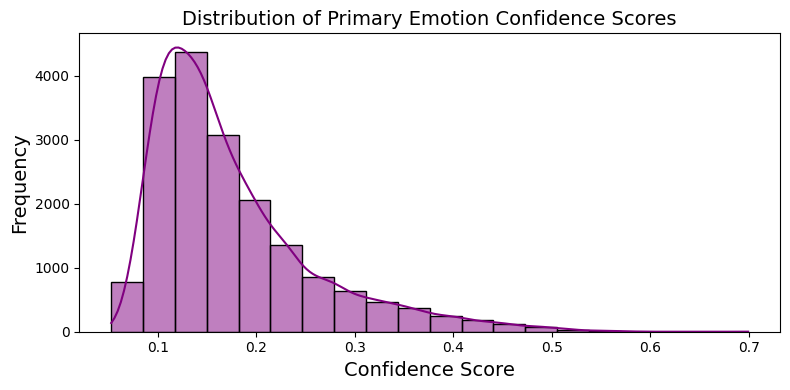

In [ ]:
# ============================================================
# Distribution of Confidence Scores for Primary Emotion
# ============================================================

# Create histogram + KDE curve for the primary emotion score (score_1)
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df,
    x="score_1",
    bins=20,           # Number of histogram bins
    kde=True,          # Overlay kernel density estimation curve
    color="purple"     # Bar and KDE color
)

# Add plot title and axis labels
plt.title("Distribution of Primary Emotion Confidence Scores", fontsize=14)
plt.xlabel("Confidence Score",fontsize=14)
plt.xticks(fontsize=10)
plt.ylabel("Frequency",fontsize=14)
plt.yticks(fontsize=10)


# Optimize layout to prevent label overlap
plt.tight_layout()
plt.show()

In [ ]:
# Check unique predicted emotions for quality control
print("Unique emotions in emotion_1 column:", df["emotion_1"].unique())

Unique emotions in emotion_1 column: ['sadness' 'disappointment' 'love' 'confusion' 'disgust' 'caring' 'fear'
 'curiosity' 'desire' 'embarrassment' 'nervousness' 'gratitude'
 'disapproval' 'annoyance' 'grief' 'realization' 'anger' 'optimism'
 'amusement' 'approval' 'relief' 'remorse' 'neutral' 'excitement'
 'surprise' 'pride' 'joy' 'admiration']


## Heuristic Mapping from Emotions to Risk Levels

To convert GoEmotions outputs into actionable **risk categories** (high / medium / low), we grouped emotions by clinical intuition and prior literature on affective risk markers. Specifically:

- **High risk**: negatively valenced, distress-oriented states (e.g., *sadness, anger, fear, disgust, grief, remorse, disappointment, disapproval, nervousness, embarrassment*).
- **Medium risk**: ambivalent or dysregulated states without clear acute distress (e.g., *confusion, annoyance, surprise, realization, neutral, caring*).
- **Low risk**: positively valenced or adaptive states (e.g., *joy, love, optimism, amusement, gratitude, relief, admiration, approval, curiosity, pride, desire, excitement*).

For each post we use the top-2 predicted emotions and assign:
1) **High** if *both* are high-risk;  
2) **Medium** if there is any mixture of high + medium, or both are medium;  
3) **Low** if *any* top-2 emotion is low-risk;  
4) **Medium** otherwise (safe fallback).

This yields a single risk label per post and a class distribution used downstream for supervised training.

In [ ]:
# ============================================================
# Map GoEmotions → Risk Levels (High / Medium / Low)
# ============================================================

# Define emotion groups (GoEmotions label set)
high_risk_emotions = {
    "sadness", "anger", "fear", "disgust", "grief",
    "remorse", "disappointment", "disapproval",
    "nervousness", "embarrassment"
}

medium_risk_emotions = {
    "confusion", "annoyance", "surprise", "realization",
    "neutral", "caring"
}

low_risk_emotions = {
    "joy", "love", "optimism", "amusement", "gratitude",
    "relief", "admiration", "approval", "curiosity",
    "pride", "desire", "excitement"
}

# Define the function to assign risk level
def get_risk_level(emotion1, emotion2):
    emotions = {str(emotion1).lower(), str(emotion2).lower()}  # set for uniqueness

    # If both emotions are high risk → high
    if emotions.issubset(high_risk_emotions):
        return 'high'

    # If at least one high risk and one medium → medium (not high)
    if any(e in high_risk_emotions for e in emotions) and any(e in medium_risk_emotions for e in emotions):
        return 'medium'

    # If both medium → medium
    if emotions.issubset(medium_risk_emotions):
        return 'medium'

    # If any emotion is low risk → low
    if any(e in low_risk_emotions for e in emotions):
        return 'low'

    # Default fallback
    return 'medium'

# Apply function to DataFrame
df['risk_level'] = df.apply(lambda row: get_risk_level(row['emotion_1'], row['emotion_2']), axis=1)

# Save the updated file
out_path = "/content/drive/MyDrive/Dissertation/reddit_risk_labeled.csv"
df.to_csv(out_path, index=False)

# Brief distribution summary for the methods section
print("Risk levels saved to:", out_path)
print("\nRisk level distribution:")
print(df["risk_level"].value_counts().to_string())

Risk levels saved to: /content/drive/MyDrive/Dissertation/reddit_risk_labeled.csv

Risk level distribution:
risk_level
high      7643
medium    7636
low       3351


## Distribution of Risk Levels

The heuristic mapping produced a balanced dataset across **medium** and **high** risk categories, with fewer posts falling into the **low** risk group. Specifically, both medium and high risk levels contain ~7,600 posts each, while the low-risk class accounts for ~3,400 posts.  

This imbalance highlights that mental health–related forums on Reddit are dominated by discussions reflecting **distress (medium/high risk)** rather than positive or adaptive states. The distribution is crucial for downstream model training, as it ensures sufficient representation of risk-bearing classes but also necessitates **class weighting** or resampling strategies to prevent bias against the minority low-risk class.

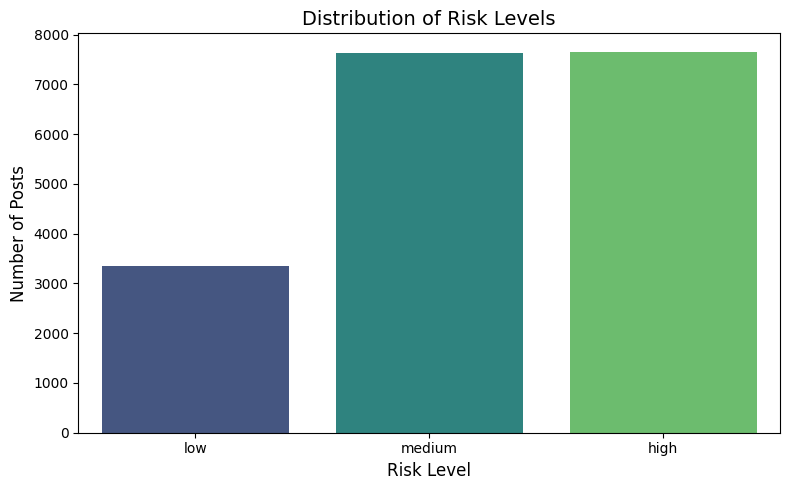

In [ ]:
# ============================================================
# Plot: Distribution of Risk Levels
# ============================================================

plt.figure(figsize=(8, 5))

# Count plot for risk levels, ordered from low to high
sns.countplot(
    data=df,
    x='risk_level',
    order=['low', 'medium', 'high'],
    palette='viridis'
)

# Title and axis labels
plt.title("Distribution of Risk Levels", fontsize=14)
plt.xlabel("Risk Level", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)

# Ensure proper layout
plt.tight_layout()
plt.show()

## Risk Level Distribution by Subreddit  

The distribution of risk levels varies substantially across subreddits. Communities such as **r/anxiety**, **r/KindVoice**, and **r/Anxietyhelp** show a predominance of **high-risk posts**, reflecting the acute emotional distress expressed by users. In contrast, forums like **r/therapy**, **r/mentalhealth**, and **r/DecidingToBeBetter** contain a higher proportion of **medium-risk posts**, suggesting a more balanced mixture of support-seeking and reflective discussions.  

The **low-risk category** remains consistently smaller across all subreddits, but is relatively more frequent in supportive or recovery-oriented forums such as **r/insomnia** and **r/selfharm**.  

This subreddit-level breakdown highlights the **context-specific nature of risk expressions**, which is crucial for interpreting model predictions and underscores the importance of considering community-level differences when deploying automated risk detection systems.

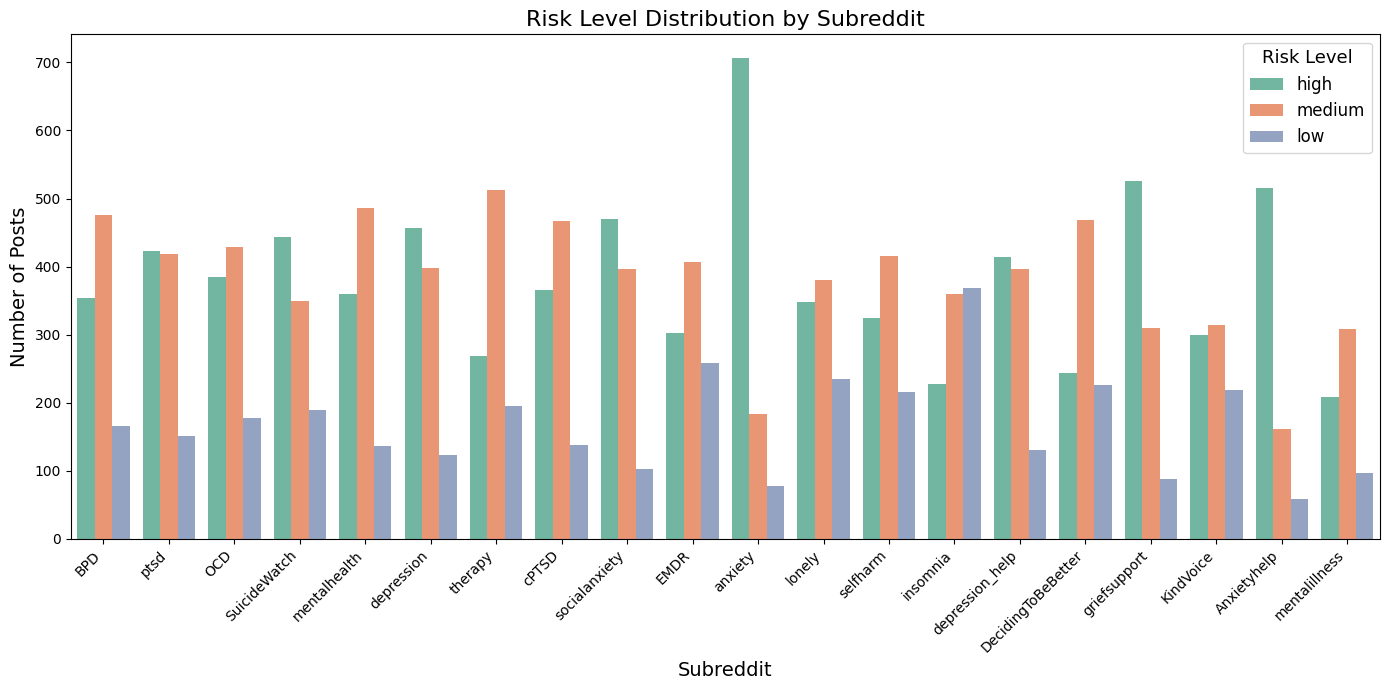

In [ ]:
# ============================================================
# Plot: Risk Level Distribution by Subreddit
# ============================================================

plt.figure(figsize=(14, 7))

# Count plot showing distribution of risk levels for each subreddit
sns.countplot(
    data=df,
    x='subreddit',
    hue='risk_level',
    order=df['subreddit'].value_counts().index,  # Order bars by subreddit frequency
    palette='Set2'
)

# Title and labels
plt.title("Risk Level Distribution by Subreddit", fontsize=16)
plt.xlabel("Subreddit", fontsize=14)
plt.ylabel("Number of Posts", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Legend settings
plt.legend(title="Risk Level", fontsize=12, title_fontsize=13)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

## Number of Posts per Subreddit  

The dataset is balanced across most subreddits, with the majority contributing close to **1,000 posts each**. Subreddits such as **r/ptsd, r/BPD, r/OCD, and r/SuicideWatch** are near the upper range (~990 posts), while smaller communities such as **r/Anxietyhelp** (740 posts) and **r/mentalillness** (608 posts) contributed fewer entries.  

This distribution confirms that the dataset achieves broad **coverage across diverse mental health communities**, while still capturing meaningful differences in subreddit size and activity. Such variation is valuable for ensuring the model is exposed to both high-volume and niche discussions, reducing bias toward larger communities.

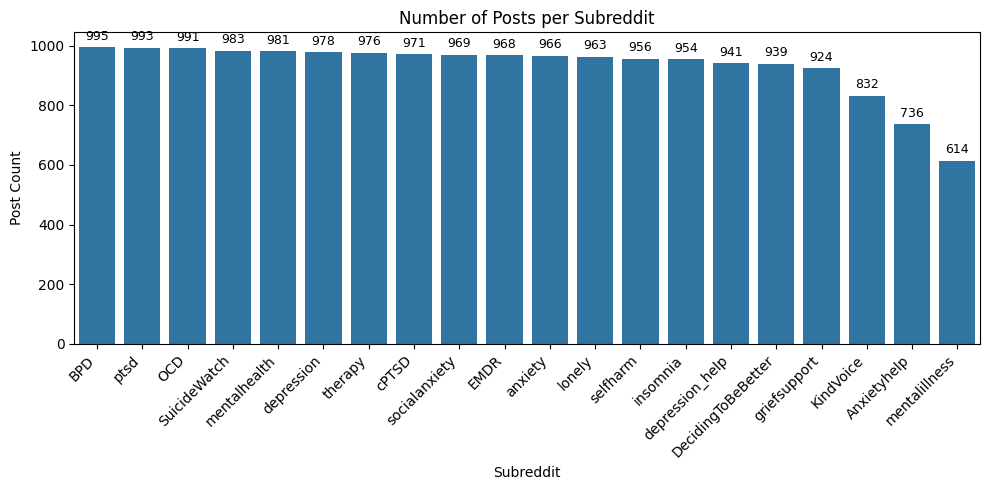

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(
    data=df,
    x='subreddit',
    order=df['subreddit'].value_counts().index
)

# Add counts on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',                     # text = height as integer
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position at center of bar
        ha='center', va='center',
        xytext=(0, 8),                                # offset above bar
        textcoords='offset points',
        fontsize=9
    )

plt.xticks(rotation=45, ha='right')
plt.title("Number of Posts per Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Post Count")
plt.tight_layout()
plt.show()

## Token Length Distribution  

The majority of Reddit posts contain fewer than **300 tokens**, with the 95th percentile at **298 tokens**. The maximum observed length was **3,831 tokens**, though such long posts are rare outliers.  

To ensure compatibility with transformer models, a **truncation threshold of 512 tokens** was applied (shown as the red dashed line). This cutoff safely retains nearly all posts without significant information loss, while aligning with BERT’s maximum input capacity.  

This analysis confirms that most user-generated content is relatively concise, allowing efficient processing while avoiding excessive truncation.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


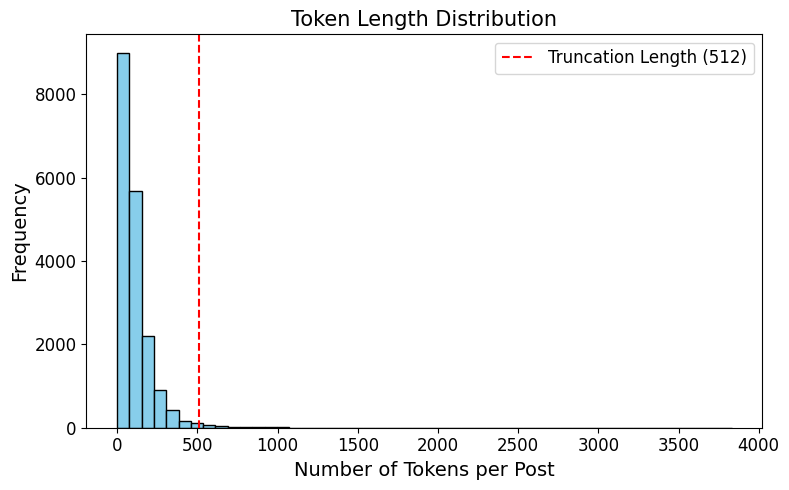

Max token length: 3831
95th percentile: 299.5499999999993


In [ ]:
# If you used a public Hugging Face model
model_checkpoint = "bert-base-uncased"

# OR if you used your fine-tuned local model
# model_checkpoint = "/content/drive/MyDrive/Dissertation/final_model/best_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenize only for length measurement
token_lengths = df['clean_text'].apply(lambda x: len(tokenizer.tokenize(str(x))))

plt.figure(figsize=(8,5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(512, color='red', linestyle='--', label='Truncation Length (512)')
plt.title("Token Length Distribution",fontsize=15)
plt.xlabel("Number of Tokens per Post",fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel("Frequency",fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"Max token length: {np.max(token_lengths)}")
print(f"95th percentile: {np.percentile(token_lengths, 95)}")

## Temporal Patterns of Risk Levels  

It illustrates the distribution of risk levels across different hours of the day. Posting activity was lowest during the early morning (06:00–09:00) and peaked in the late evening (21:00–23:00).  

High- and medium-risk posts followed similar temporal trends, with elevated activity during late-night hours, suggesting that individuals may be more likely to share distress-related content during periods of solitude or reduced social interaction. Low-risk posts, while consistently fewer in number, also showed a slight increase during evening hours.  

These findings highlight a temporal dimension to online help-seeking behavior, reinforcing prior evidence that mental health concerns are more frequently expressed during nighttime hours.

In [ ]:
# ============================================================
# Convert 'created_utc' to datetime format
# ============================================================

# Case 1: If 'created_utc' contains UNIX timestamps (numeric)
if np.issubdtype(df['created_utc'].dtype, np.number):
    df['created_at'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')

# Case 2: If 'created_utc' contains ISO string timestamps (text)
else:
    df['created_at'] = pd.to_datetime(df['created_utc'], errors='coerce')

# Optional: Extract date and time components
df['date'] = df['created_at'].dt.date
df['hour'] = df['created_at'].dt.hour

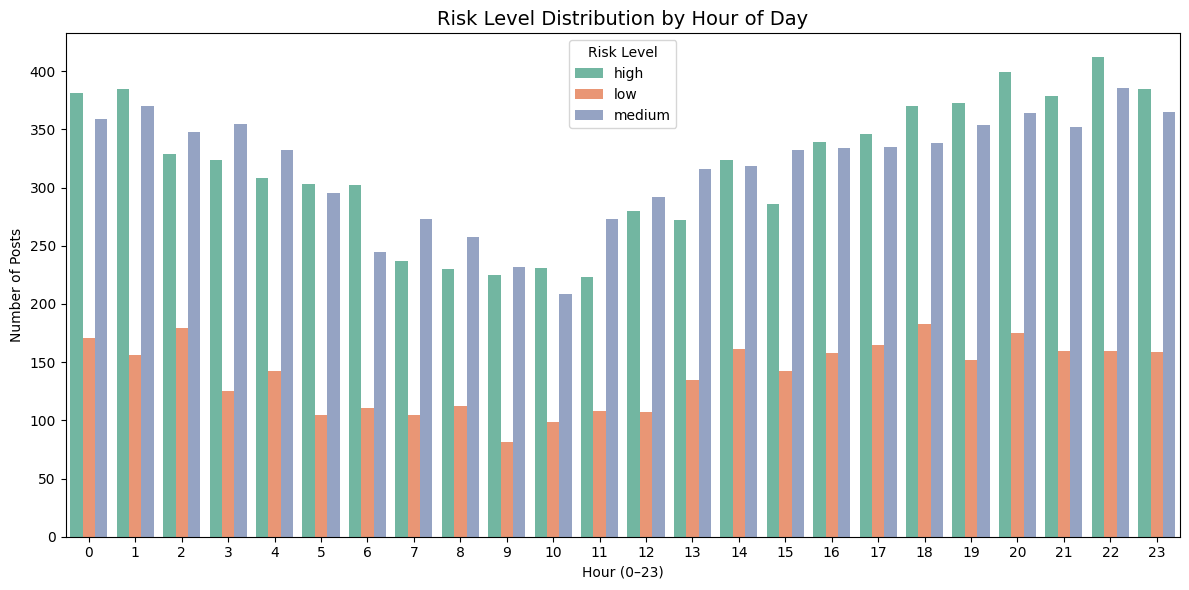

In [ ]:
# ============================================================
# Risk Level Distribution by Hour of Day
# ============================================================

# Ensure 'hour' exists; if missing, extract from 'created_at'
if "hour" not in df.columns:
    df["hour"] = df["created_at"].dt.hour

# Replace missing values with -1 (placeholder) before type conversion
df["hour"] = df["hour"].fillna(-1).astype(int)

# Filter out placeholder values so only valid hours remain
hour_df = df[df["hour"] >= 0]

# Create count plot grouped by hour and colored by risk level
plt.figure(figsize=(12, 6))
sns.countplot(
    data=hour_df,
    x="hour",
    hue="risk_level",
    palette="Set2",
    order=range(24)  # Ensures 0–23 order on x-axis
)

# Add descriptive labels and title
plt.title("Risk Level Distribution by Hour of Day", fontsize=14)
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Posts")
plt.legend(title="Risk Level")

# Optimize layout for better readability
plt.tight_layout()
plt.show()

## Emotion Distribution in High-Risk Posts  

Figure X highlights the most frequent emotions identified within posts categorized as high risk. The most dominant signals were *nervousness*, *sadness*, and *disappointment*, together accounting for the majority of high-risk content. Secondary but notable emotions included *fear* and *embarrassment*, while expressions of *anger*, *disgust*, *remorse*, *grief*, and *disapproval* occurred less frequently.  

This distribution suggests that high-risk posts are primarily characterized by internalized distress and apprehension, rather than outwardly expressed hostility. Such insights provide evidence that early-warning systems should focus on detecting subtle signals of anxiety and sadness, which are more prevalent than overt anger or grief.

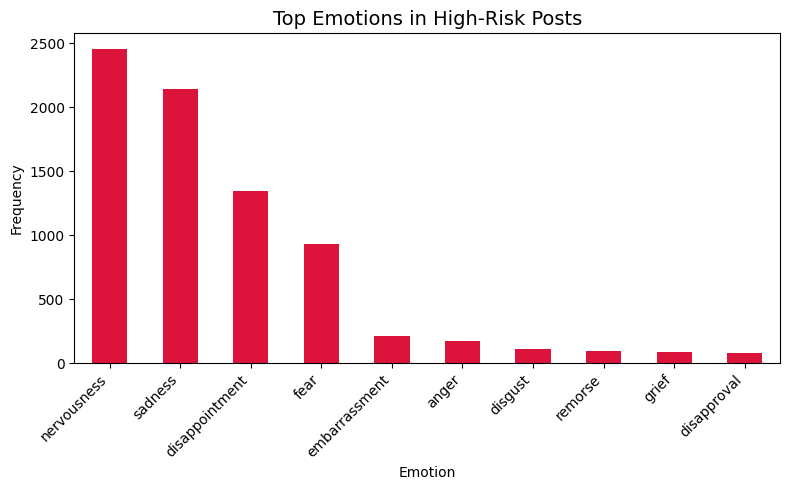

In [ ]:
# ============================================================
# Frequency Distribution of Primary Emotions in High-Risk Posts
# ============================================================

# Filter posts labeled as 'high' risk and count occurrences of the primary emotion (emotion_1)
high_risk_emotions = (
    df[df["risk_level"] == "high"]["emotion_1"]
    .value_counts()
)

# Create bar plot for the top emotions in high-risk posts
high_risk_emotions.plot(
    kind="bar",
    color="crimson",  # Red shade for high-risk emphasis
    figsize=(8, 5)
)

# Add plot title and axis labels
plt.title("Top Emotions in High-Risk Posts", fontsize=14)
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability

# Optimize layout
plt.tight_layout()
plt.show()

## Word Clouds by Risk Level  

To gain qualitative insight into language patterns across risk categories, word clouds were generated for posts labeled as *low*, *medium*, and *high* risk. Each word cloud highlights the most frequent terms within that risk group, providing an intuitive visualization of recurring themes.  

Low-risk posts prominently featured positive and supportive terms, reflecting encouragement and self-improvement. Medium-risk posts displayed a mix of emotional expressions and coping strategies, indicating transitional states of distress. High-risk posts were dominated by words associated with fear, sadness, and struggle, consistent with severe emotional distress.  

These visualizations complement the quantitative distributions by showing how the vocabulary shifts with increasing risk, strengthening the interpretability of the dataset.

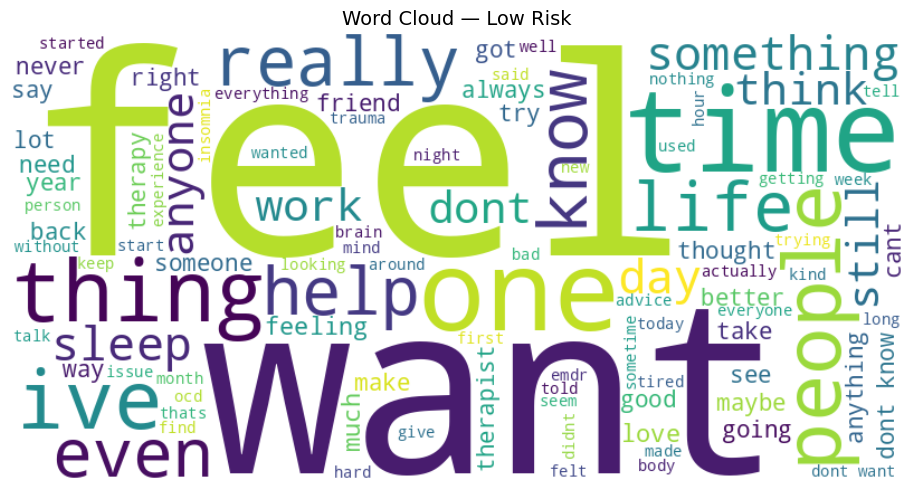

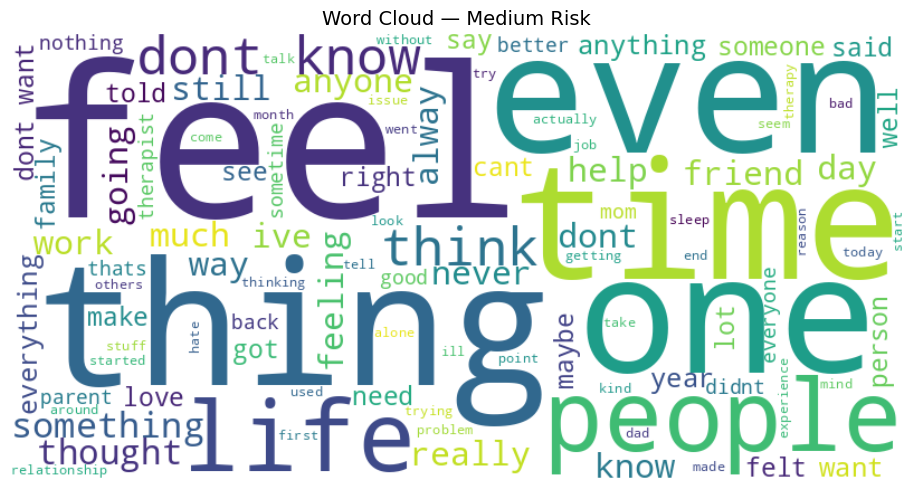

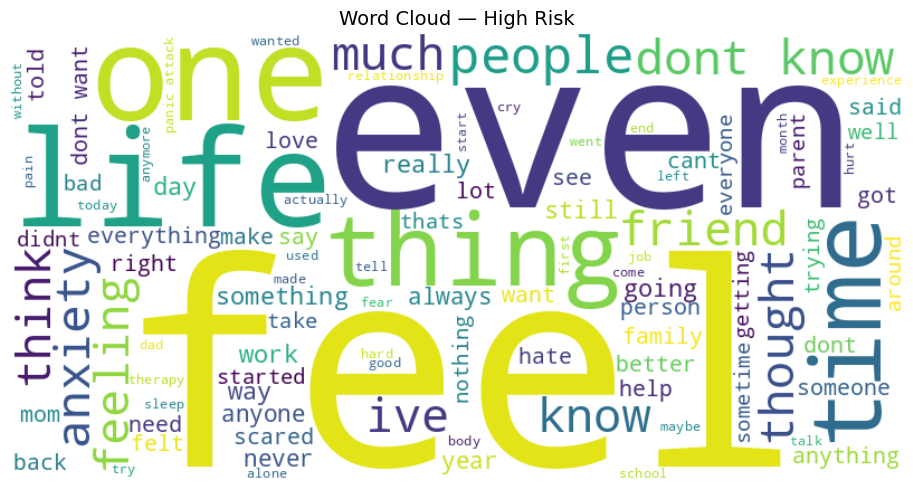

In [ ]:
# ============================================================
# Word Clouds by Risk Level (uses pre-imported WordCloud)
# ============================================================

# Determine a consistent display order if these classes exist
risk_order = [c for c in ["low", "medium", "high"] if c in df["risk_level"].unique()]

for level in risk_order:
    # Select and concatenate cleaned text for the current risk level
    level_text_series = df.loc[df["risk_level"] == level, "clean_text"].dropna()
    combined_text = " ".join(level_text_series.tolist())

    # Skip plotting if there is no text (prevents empty word clouds)
    if not combined_text.strip():
        print(f"No text available for risk level: {level}")
        continue

    # Create the word cloud object (colormap chosen to match earlier figures)
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap="viridis",
        max_words=100
    ).generate(combined_text)

    # Render the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud — {level.capitalize()} Risk", fontsize=14)
    plt.tight_layout()
    plt.show()

# Model Development and Evaluation  

This section outlines the approach taken to train and evaluate machine learning models for mental health risk classification. The primary aim was to predict the risk level (*low, medium, high*) of Reddit posts based on linguistic and emotional features. Both traditional machine learning baselines and transformer-based deep learning models were considered to establish comparative performance benchmarks.  

## Baseline Model: Logistic Regression with TF–IDF  
As an interpretable baseline, a Logistic Regression model was trained using TF–IDF representations of the cleaned text. This method captures term frequency patterns and provides a benchmark for more advanced models. Despite its simplicity, TF–IDF + Logistic Regression has proven effective in text classification tasks and serves as a useful reference point.  

## Transformer Models  
Given the recent advances in Natural Language Processing, transformer architectures were explored for improved performance:  

- **BERT (Bidirectional Encoder Representations from Transformers):** A widely used pre-trained language model capable of contextual embedding representation.  
- **DistilBERT:** A distilled, lightweight version of BERT offering faster training with minimal loss in accuracy. This model was selected as the *primary architecture* due to its balance between efficiency and performance.  

## Model Customisation  
For the transformer models, the following customisations were implemented:  
- **Pooling Strategy:** Combined *mean* and *max* pooling over token embeddings to capture both average context and salient features.  
- **Loss Function:** Class-weighted cross-entropy was applied to address label imbalance across the three risk categories.  
- **Training Strategy:** Early stopping was employed to prevent overfitting and improve generalisation.  

## Evaluation Metrics  
Models were assessed using multiple metrics to provide a comprehensive evaluation:  
- **Accuracy** – overall correctness of predictions.  
- **Macro F1-score** – equally weighted performance across all classes.  
- **Weighted F1-score** – adjusted for class distribution imbalance.  
- **Confusion Matrix** – to examine class-specific errors and misclassifications.  

## Implementation Details  
- **Frameworks:** Hugging Face Transformers, PyTorch, and Scikit-learn.   
- **Hyperparameters:**  
  - Epochs: 5 (with early stopping)  
  - Batch size: 16  
  - Learning rate: 2e-5  
  - Maximum token length: 512 (95th percentile ≈ 298 tokens ensured minimal truncation).  

## Cross-Validation & Test Strategy  
To ensure robust model evaluation, a **5-Fold Cross-Validation (CV)** approach was adopted on the training/validation set. This method partitions the dataset into five folds, iteratively training on four folds while validating on the remaining one, thus reducing bias from any single split.  

- **Cross-Validation Phase:** Used to tune hyperparameters and monitor generalisation across folds.  
- **Final Test Phase:** After cross-validation, the best-performing configuration was retrained on the entire training set and evaluated on a **held-out 20% test set** that was never seen during training or validation.  
- **Benefits:** This strategy provides both a stable performance estimate (via CV) and a realistic assessment of model generalisation (via the held-out test set).  

A schematic diagram of the experimental pipeline is provided in the appendix for visual clarity.

In [ ]:
# ================================================================
# Complete Training & Evaluation Pipeline (Single Cell)
#
# Models evaluated on the same held-out test split:
#   1) DistilBERT — Mean+Max pooling, projection, and Multi-Sample Dropout (5-fold CV + Final Test)  [Main Model]
#   2) BERT-base — Mean+Max pooling, projection, and Multi-Sample Dropout (Final Test)
#   3) DistilBERT — Hugging Face reference classification head (Final Test)
#   4) BERT-base — Hugging Face reference classification head (Final Test)
#   5) TF–IDF + Logistic Regression baseline (Final Test)
#   6) DistilBERT — CLS pooling, Tanh pre-classifier, and Multi-Sample Dropout (Final Test)
#   7) DistilBERT — Attention pooling, Tanh pre-classifier, and Multi-Sample Dropout (Final Test)
#
# Customisation applied in the experimental heads:
#   • Mean+Max pooling (main), CLS token pooling, or self-attention pooling
#   • Lightweight projection (Linear → GELU → Dropout) before the classifier
#   • Multi-Sample Dropout (MSD) classification head
#   • Class-weighted CrossEntropy with label smoothing
#   • R-Drop regularisation (symmetric KL between two forward passes)
#   • Layer-wise Learning-Rate Decay (LLRD)
#   • Exponential Moving Average (EMA) of weights
#
# Artifacts generated:
#   - Per-fold metrics & predictions
#   - Final classification reports & predictions
#   - cross_validation_metrics_distilbert_mnmx_msd.csv
#   - model_comparison_final_test.csv
#   - Robust saved models (pytorch_model.bin + tokenizer + model_meta.json)
# ================================================================


# ----------------------------
# Project paths
# ----------------------------
BASE_DIR = Path("/content/drive/MyDrive/Dissertation")  # Root directory for all artifacts

# DistilBERT (Mean+Max + projection + MSD) — main model
DISTIL_ENH_RESULTS = BASE_DIR / "distilbert_mnmx_msd_results"  # Per-fold outputs (CV)
DISTIL_ENH_LOGS    = BASE_DIR / "distilbert_mnmx_msd_logs"     # Training logs
DISTIL_ENH_SAVED   = BASE_DIR / "distilbert_mnmx_msd_saved"    # Saved packages per fold
DISTIL_ENH_FINAL   = BASE_DIR / "distilbert_mnmx_msd_final"    # Final model after full train/val

# BERT (Mean+Max + projection + MSD)
BERT_ENH_FINAL     = BASE_DIR / "bert_poolproj_msd_final"      # Keep as-is to preserve your directory structure

# Reference heads (HF standard)
DISTIL_REF_FINAL   = BASE_DIR / "distilbert_reference_final"   # Distil reference head outputs
BERT_REF_FINAL     = BASE_DIR / "bert_reference_final"         # BERT reference head outputs

# Pooling variants with MSD (CLS vs Attention)
CLS_MSD_FINAL      = BASE_DIR / "distilbert_cls_msd_final"     # Distil with CLS pooling + MSD
ATTN_MSD_FINAL     = BASE_DIR / "distilbert_attn_msd_final"    # Distil with attention pooling + MSD

# Comparison table path
COMPARISON_CSV     = BASE_DIR / "model_comparison_final_test.csv"  # Model comparison summary

# Ensure directories exist before training starts
for p in [
    BASE_DIR, DISTIL_ENH_RESULTS, DISTIL_ENH_LOGS, DISTIL_ENH_SAVED, DISTIL_ENH_FINAL,
    BERT_ENH_FINAL, DISTIL_REF_FINAL, BERT_REF_FINAL, CLS_MSD_FINAL, ATTN_MSD_FINAL
]:
    p.mkdir(parents=True, exist_ok=True)  # Create directories recursively if missing

# ----------------------------
# Data loading and split
# ----------------------------
csv_path = BASE_DIR / "reddit_risk_labeled.csv"  # Path to CSV with 'clean_text' and 'risk_level'
df = (
    pd.read_csv(csv_path)                        # Load the dataset into a DataFrame
      .dropna(subset=["clean_text", "risk_level"])  # Remove rows with missing text/label
      .reset_index(drop=True)                    # Reset index for a clean, contiguous DataFrame
)

label_encoder = LabelEncoder()                   # Instantiate label encoder
df["label"] = label_encoder.fit_transform(df["risk_level"])  # Encode labels to integers
classes = list(label_encoder.classes_)           # Store class names for reports
num_labels = len(classes)                        # Number of classes in the task
print(f"Detected classes: {classes} (num_labels={num_labels})")  # Log label space

# Stratified 80/20 split to preserve class ratio in both splits
train_val_df, test_df_final = train_test_split(
    df, test_size=0.20, stratify=df["label"], random_state=SEED
)
print(f"Train/Val size: {len(train_val_df)} | Final Test size: {len(test_df_final)}")  # Log sizes

# ----------------------------
# Tokenisation helpers and metrics
# ----------------------------
def get_tokenizer_and_collator(model_ckpt: str):
    """Create a tokenizer and a dynamic-padding collator for the given checkpoint."""
    tok = AutoTokenizer.from_pretrained(model_ckpt)           # Load matching tokenizer
    collator = DataCollatorWithPadding(tokenizer=tok)         # Dynamic padding at batch time
    return tok, collator                                      # Return both for Trainer

def tokenize_fn_builder(tokenizer: AutoTokenizer):
    """Return a function that tokenises the 'clean_text' field with truncation."""
    def _fn(example: Dict[str, Any]) -> Dict[str, Any]:       # HF Datasets mapping fn signature
        return tokenizer(example["clean_text"], truncation=True)  # Truncate to model max length
    return _fn

def compute_metrics(eval_pred):
    """Compute Accuracy, Weighted F1, and Macro F1 from logits and labels."""
    logits, labels = eval_pred                                # Unpack predicted logits and true labels
    preds = np.argmax(logits, axis=1)                         # Convert logits to predicted class ids
    return {
        "accuracy":    accuracy_score(labels, preds),         # Overall accuracy
        "f1_weighted": f1_score(labels, preds, average="weighted"),  # F1 weighted by support
        "f1_macro":    f1_score(labels, preds, average="macro"),     # Unweighted mean F1
    }

# ----------------------------
# Building blocks for enhanced heads
# ----------------------------
class _MeanMaxPool(nn.Module):
    """Mask-aware Mean+Max pooling over token embeddings; output dimension is 2H."""
    def forward(self, last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).float()           # (B, L) → (B, L, 1) for broadcasting
        x = last_hidden_state * mask                          # Zero-out padded token embeddings

        denom = mask.sum(dim=1).clamp(min=1e-9)              # Count of valid tokens; clamp avoids division by zero
        mean_pool = x.sum(dim=1) / denom                     # Mean pooling over valid tokens (B, H)

        x_masked = x + (1.0 - mask) * (-1e9)                 # Push pads to -inf so they don't affect max
        max_pool, _ = x_masked.max(dim=1)                    # Max pooling across tokens (B, H)

        return torch.cat([mean_pool, max_pool], dim=1)       # Concatenate mean and max → (B, 2H)

class _MSDHead(nn.Module):
    """Multi-Sample Dropout head: average logits across several dropout rates."""
    def __init__(self, in_features: int, num_labels: int, p_list=(0.10, 0.20, 0.30, 0.40, 0.50)):
        super().__init__()
        self.dropouts = nn.ModuleList([nn.Dropout(p) for p in p_list])  # Multiple dropout layers
        self.out = nn.Linear(in_features, num_labels)                   # Final classification layer

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = [self.out(drop(x)) for drop in self.dropouts]          # Logits per dropout path
        return torch.stack(logits, dim=0).mean(dim=0)                   # Average logits across paths

class DistilTextClassifier_MeanMax(nn.Module):
    """DistilBERT encoder → Mean+Max pooling → projection → MSD classifier."""
    def __init__(self, model_name="distilbert-base-uncased", num_labels=3,
                 dropout=0.2, id2label=None, label2id=None,
                 class_weights=None, label_smoothing=0.05):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)           # Load DistilBERT encoder
        hidden = self.backbone.config.dim                               # Hidden size (usually 768)

        self.pool = _MeanMaxPool()                                      # Mean+Max pooling module
        self.proj = nn.Sequential(                                      # Lightweight projection head
            nn.Linear(2 * hidden, hidden),                              # 2H → H
            nn.GELU(),                                                  # Nonlinearity
            nn.Dropout(dropout)                                         # Regularisation
        )
        self.head = _MSDHead(hidden, num_labels)                        # MSD classifier

        self.config = self.backbone.config                              # Keep HF config with label maps
        if id2label is not None: self.config.id2label = id2label        # id → label
        if label2id is not None: self.config.label2id = label2id        # label → id

        self.register_buffer("class_weights",
                             class_weights.float() if class_weights is not None else None)  # Optional class weights
        self.label_smoothing = float(label_smoothing)                   # Label smoothing value

    def forward(self, input_ids=None, attention_mask=None, labels=None) -> Dict[str, torch.Tensor]:
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)  # Encoder forward
        features = self.proj(self.pool(out.last_hidden_state, attention_mask))                     # Pool then project
        logits = self.head(features)                                                                # Class logits

        loss = None
        if labels is not None:
            ce = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=self.label_smoothing)  # Weighted CE
            loss = ce(logits, labels)                                                                   # Compute loss
        return {"loss": loss, "logits": logits}                                                         # Return dict for Trainer

class BERTTextClassifier_MeanMax(nn.Module):
    """BERT encoder → Mean+Max pooling → projection → MSD classifier."""
    def __init__(self, model_name="bert-base-uncased", num_labels=3,
                 dropout=0.2, id2label=None, label2id=None,
                 class_weights=None, label_smoothing=0.05):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)           # Load BERT encoder
        hidden = getattr(self.backbone.config, "hidden_size", None) or getattr(self.backbone.config, "dim")  # Hidden size

        self.pool = _MeanMaxPool()                                      # Mean+Max pooling
        self.proj = nn.Sequential(                                      # Projection head
            nn.Linear(2 * hidden, hidden),                              # 2H → H
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.head = _MSDHead(hidden, num_labels)                        # MSD classifier

        self.config = self.backbone.config                              # Keep HF config consistent
        if id2label is not None: self.config.id2label = id2label
        if label2id is not None: self.config.label2id = label2id

        self.register_buffer("class_weights",
                             class_weights.float() if class_weights is not None else None)  # Optional class weights
        self.label_smoothing = float(label_smoothing)                   # Label smoothing parameter

    def forward(self, input_ids=None, attention_mask=None, labels=None) -> Dict[str, torch.Tensor]:
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)  # Encode
        features = self.proj(self.pool(out.last_hidden_state, attention_mask))                     # Pool+project
        logits = self.head(features)                                                                # Logits

        loss = None
        if labels is not None:
            ce = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=self.label_smoothing)  # Weighted CE
            loss = ce(logits, labels)                                                                   # Loss
        return {"loss": loss, "logits": logits}                                                         # Trainer-compatible dict

# ----------------------------
# Pooling variants (CLS vs Attention) with MSD
# ----------------------------
class AttentionPooling(nn.Module):
    """Single-query attention pooling with mask support (returns a weighted sum of token embeddings)."""
    def __init__(self, hidden_size: int):
        super().__init__()
        self.proj = nn.Linear(hidden_size, hidden_size)       # Token-wise projection before scoring
        self.u = nn.Linear(hidden_size, 1, bias=False)        # Score generator per token

    def forward(self, hidden: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = torch.tanh(self.proj(hidden))                     # Nonlinear transform of token embeddings
        scores = self.u(x).squeeze(-1)                        # Unnormalised token scores (B, L)
        scores = scores.masked_fill(mask == 0, -1e9)          # Suppress padded positions
        attn = torch.softmax(scores, dim=1)                   # Attention weights over tokens (B, L)
        return torch.bmm(attn.unsqueeze(1), hidden).squeeze(1)  # Weighted sum → (B, H)

class DistilTextClassifier_PoolHead(nn.Module):
    """DistilBERT encoder → pooling ('cls' or 'attn') → Linear→Tanh→Dropout → MSD classifier."""
    def __init__(self, model_name="distilbert-base-uncased", num_labels=3,
                 pooling="cls", class_weights=None, label_smoothing=0.05, dropout=0.1):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)  # DistilBERT encoder
        hidden = self.backbone.config.dim                      # Hidden dimension
        self.pooling = pooling.lower()                         # Pooling choice

        if self.pooling == "attn":
            self.pool = AttentionPooling(hidden)               # Attention pooling module
            pooled_dim = hidden                                # Output dim equals hidden size
        else:
            self.pool = None                                   # CLS pooling path
            pooled_dim = hidden                                # Using hidden[0] representation

        self.pre = nn.Linear(pooled_dim, hidden)               # Pre-classifier linear layer
        self.act = nn.Tanh()                                    # Nonlinearity
        self.drop = nn.Dropout(dropout)                         # Regularisation
        self.head = _MSDHead(hidden, num_labels)                # MSD classifier

        self.register_buffer("class_weights",
                             class_weights.float() if class_weights is not None else None)  # Optional class weights
        self.label_smoothing = float(label_smoothing)           # Label smoothing parameter

    def forward(self, input_ids=None, attention_mask=None, labels=None) -> Dict[str, torch.Tensor]:
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)  # Encode
        hidden = out.last_hidden_state                         # Token representations
        feat = self.pool(hidden, attention_mask) if self.pooling == "attn" else hidden[:, 0, :]    # Pooled feature
        x = self.drop(self.act(self.pre(feat)))                # Pre-classifier sequence
        logits = self.head(x)                                  # Class logits

        loss = None
        if labels is not None:
            ce = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=self.label_smoothing)  # CE loss
            loss = ce(logits, labels)                                                                   # Loss value
        return {"loss": loss, "logits": logits}                                                         # Output dict

# ----------------------------
# EMA utility (Exponential Moving Average of weights)
# ----------------------------
class SimpleEMA:
    """Maintain an EMA of trainable parameters and provide apply/restore helpers for eval/predict."""
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay = decay                                      # EMA decay (closer to 1.0 → slower changes)
        self.shadow: Dict[str, torch.Tensor] = {}               # EMA weights
        self.backup: Dict[str, torch.Tensor] = {}               # Original weights for restoration
        for n, p in model.named_parameters():                   # Iterate model parameters
            if p.requires_grad:
                self.shadow[n] = p.detach().clone()             # Start EMA from initial weights

    @torch.no_grad()
    def _ensure_device(self, t: torch.Tensor, device: torch.device):
        return t if t.device == device else t.to(device)        # Move EMA tensors to the model device if needed

    @torch.no_grad()
    def update(self, model: nn.Module):
        for n, p in model.named_parameters():                   # Update EMA after optimizer steps
            if not p.requires_grad:
                continue
            if n not in self.shadow:
                self.shadow[n] = p.detach().clone()
            self.shadow[n] = self._ensure_device(self.shadow[n], p.device)
            self.shadow[n].mul_(self.decay).add_(p.detach(), alpha=(1.0 - self.decay))  # EMA formula

    @torch.no_grad()
    def apply_to(self, model: nn.Module):
        self.backup = {}                                        # Store current weights
        for n, p in model.named_parameters():
            if not p.requires_grad:
                continue
            ema_t = self._ensure_device(self.shadow[n], p.device)
            self.backup[n] = p.detach().clone()
            p.data.copy_(ema_t.data)                            # Replace with EMA weights

    @torch.no_grad()
    def restore(self, model: nn.Module):
        for n, p in model.named_parameters():                   # Restore original weights post-eval
            if not p.requires_grad:
                continue
            p.data.copy_(self.backup[n].data)

# ----------------------------
# Trainer extension: R-Drop + EMA + shape-safe prediction_step
# ----------------------------
class TrainerWithRDrop(HFTrainer):
    """Extend HF Trainer with R-Drop consistency loss and EMA support."""
    def __init__(self, *args, ema: SimpleEMA | None = None,
                 rdrop_alpha: float = 5e-3, label_smoothing: float = 0.05,
                 class_weights: torch.Tensor | None = None, **kwargs):
        super().__init__(*args, **kwargs)
        self.ema = ema                                         # EMA controller
        self.rdrop_alpha = rdrop_alpha                          # Weight for symmetric KL
        self.label_smoothing = label_smoothing                  # Label smoothing for CE
        self.class_weights = class_weights                      # Class weights tensor (or None)

    def compute_loss(self, model, inputs, return_outputs=False):
        """Two passes through the model + CE loss + symmetric KL divergence."""
        labels = inputs.get("labels")                           # Ground-truth labels

        out1 = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])  # Forward pass 1
        logits1 = out1["logits"]                                # Logits from the first pass
        out2 = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])  # Forward pass 2
        logits2 = out2["logits"]                                # Logits from the second pass

        ce = nn.CrossEntropyLoss(                               # CE with optional class weights and smoothing
            weight=(self.class_weights.to(logits1.device) if self.class_weights is not None else None),
            label_smoothing=self.label_smoothing
        )
        ce_loss = 0.5 * ce(logits1, labels) + 0.5 * ce(logits2, labels)  # Average CE across the two passes

        p1 = F.log_softmax(logits1, dim=-1); q1 = p1.exp()      # Log-probs and probs for pass 1
        p2 = F.log_softmax(logits2, dim=-1); q2 = p2.exp()      # Log-probs and probs for pass 2
        kl = 0.5 * (F.kl_div(p1, q2, reduction="batchmean") + F.kl_div(p2, q1, reduction="batchmean"))  # Symmetric KL

        loss = ce_loss + self.rdrop_alpha * kl                  # Total loss
        return (loss, logits1) if return_outputs else loss      # Return as expected by Trainer

    def training_step(self, *args, **kwargs):
        """Standard training step followed by EMA update after effective optimizer step."""
        loss = super().training_step(*args, **kwargs)           # Usual Trainer step
        if (self.ema is not None and self.state.global_step > 0 and
            self.state.global_step % self.args.gradient_accumulation_steps == 0):
            self.ema.update(self.model)                         # Update EMA once per effective step
        return loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        """Apply EMA weights for evaluation and restore afterwards."""
        if self.ema is not None:
            self.ema.apply_to(self.model)                       # Swap in EMA weights
        out = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
        if self.ema is not None:
            self.ema.restore(self.model)                        # Restore original weights
        return out

    def predict(self, test_dataset, ignore_keys=None, metric_key_prefix="test"):
        """Apply EMA weights for prediction and restore afterwards."""
        if self.ema is not None:
            self.ema.apply_to(self.model)                       # Swap in EMA weights
        out = super().predict(test_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
        if self.ema is not None:
            self.ema.restore(self.model)                        # Restore original weights
        return out

    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """Single forward at eval time to keep shapes consistent with compute_metrics."""
        has_labels = "labels" in inputs                         # Whether labels are provided
        inputs = self._prepare_inputs(inputs)                   # Move/cast tensors
        with torch.no_grad():
            outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])  # Forward
            logits = outputs["logits"]                          # Logits for metrics

        loss = None; labels = None
        if has_labels:
            labels = inputs["labels"]                           # Extract labels
            ce = nn.CrossEntropyLoss(                           # CE with the same smoothing/weights
                weight=(self.class_weights.to(logits.device) if self.class_weights is not None else None),
                label_smoothing=self.label_smoothing
            )
            loss = ce(logits, labels)                           # Compute evaluation loss

        if prediction_loss_only:
            return (loss, None, None)                           # Return only loss if requested
        return (loss, logits, labels)                           # Tuple expected by Trainer

class TrainerWithRDrop_Distil(TrainerWithRDrop):
    """Add layer-wise LR decay groups for DistilBERT (6 transformer layers)."""
    def create_optimizer(self):
        if self.optimizer is not None:
            return self.optimizer                                # Reuse if already created

        def no_decay(name: str) -> bool:
            return any(k in name for k in ["bias", "LayerNorm.weight", "LayerNorm.bias"])  # Parameters without WD

        lr_base = self.args.learning_rate                        # Base LR from TrainingArguments
        lr_decay = 0.95                                          # Decay factor across layers
        named = list(self.model.named_parameters())              # All named parameters
        groups = []                                              # Param groups with distinct LRs

        # Embeddings (lowest LR)
        emb = [(n, p) for (n, p) in named if "embeddings" in n]
        for no_wd in [False, True]:
            params = [p for (n, p) in emb if no_decay(n) == no_wd]
            if params:
                groups.append({
                    "params": params,
                    "weight_decay": 0.0 if no_wd else self.args.weight_decay,
                    "lr": lr_base * (lr_decay ** 6)
                })

        # Transformer layers 0..5 (higher layers → larger LR)
        for layer in range(6):
            lp = [(n, p) for (n, p) in named if f"transformer.layer.{layer}." in n]
            if not lp:
                continue
            scale = lr_decay ** (5 - layer)                      # Less decay for higher layers
            for no_wd in [False, True]:
                params = [p for (n, p) in lp if no_decay(n) == no_wd]
                if params:
                    groups.append({
                        "params": params,
                        "weight_decay": 0.0 if no_wd else self.args.weight_decay,
                        "lr": lr_base * scale
                    })

        # Task head (pool/proj/msd) at full LR
        head = [(n, p) for (n, p) in named if ("embeddings" not in n and "transformer.layer" not in n)]
        for no_wd in [False, True]:
            params = [p for (n, p) in head if no_decay(n) == no_wd]
            if params:
                groups.append({
                    "params": params,
                    "weight_decay": 0.0 if no_wd else self.args.weight_decay,
                    "lr": lr_base
                })

        self.optimizer = torch.optim.AdamW(groups, lr=lr_base, betas=(0.9, 0.999), eps=1e-8)  # AdamW with groups
        return self.optimizer

class TrainerWithRDrop_BERT(TrainerWithRDrop):
    """Add layer-wise LR decay groups for BERT (12 encoder layers)."""
    def create_optimizer(self):
        if self.optimizer is not None:
            return self.optimizer                                # Use existing optimizer if present

        def no_decay(name: str) -> bool:
            return any(k in name for k in ["bias", "LayerNorm.weight", "LayerNorm.bias"])  # Parameters without WD

        lr_base = self.args.learning_rate                        # Base LR
        lr_decay = 0.95                                          # Decay factor across layers
        named = list(self.model.named_parameters())              # All parameters
        groups = []                                              # Param groups

        # Embeddings (lowest LR)
        emb = [(n, p) for (n, p) in named if "embeddings" in n]
        for no_wd in [False, True]:
            params = [p for (n, p) in emb if no_decay(n) == no_wd]
            if params:
                groups.append({
                    "params": params,
                    "weight_decay": 0.0 if no_wd else self.args.weight_decay,
                    "lr": lr_base * (lr_decay ** 12)
                })

        # Encoder layers 0..11
        MAX_L = 11
        for layer in range(MAX_L + 1):
            lp = [(n, p) for (n, p) in named if f"encoder.layer.{layer}." in n]
            if not lp:
                continue
            scale = lr_decay ** (MAX_L - layer)                  # Less decay for higher layers
            for no_wd in [False, True]:
                params = [p for (n, p) in lp if no_decay(n) == no_wd]
                if params:
                    groups.append({
                        "params": params,
                        "weight_decay": 0.0 if no_wd else self.args.weight_decay,
                        "lr": lr_base * scale
                    })

        # Task head (pool/proj/msd) at full LR
        head = [(n, p) for (n, p) in named if ("embeddings" not in n and "encoder.layer" not in n)]
        for no_wd in [False, True]:
            params = [p for (n, p) in head if no_decay(n) == no_wd]
            if params:
                groups.append({
                    "params": params,
                    "weight_decay": 0.0 if no_wd else self.args.weight_decay,
                    "lr": lr_base
                })

        self.optimizer = torch.optim.AdamW(groups, lr=lr_base, betas=(0.9, 0.999), eps=1e-8)  # AdamW with groups
        return self.optimizer

# ----------------------------
# Robust saver for enhanced heads
# ----------------------------
def save_enhanced_package(model: nn.Module, tokenizer: AutoTokenizer, out_dir: Path, meta: Dict[str, Any]) -> None:
    """Persist model weights, tokenizer files, and minimal metadata for reloading."""
    out_dir.mkdir(parents=True, exist_ok=True)                   # Ensure destination exists
    torch.save(model.state_dict(), out_dir / "pytorch_model.bin")  # Save only state_dict
    tokenizer.save_pretrained(out_dir)                           # Save tokenizer (vocab + config)
    with open(out_dir / "model_meta.json", "w") as f:
        json.dump(meta, f, indent=2)                             # Metadata for reproducible inference
    print(f"Saved package → {out_dir}")                          # Log save location

# ----------------------------
# DistilBERT — Mean+Max + projection + MSD (CV + Final)
# ----------------------------
distil_ckpt = "distilbert-base-uncased"                          # HF checkpoint name for DistilBERT
tok_main, col_main = get_tokenizer_and_collator(distil_ckpt)     # Tokenizer and collator for DistilBERT

def run_distil_enhanced_cv_and_final(
    train_val_df: pd.DataFrame,
    test_df_final: pd.DataFrame,
    epochs=5, batch_size=16, lr=2e-5,
    label_smoothing=0.05, rdrop_alpha=5e-3, ema_decay=0.999
):
    """Run 5-fold CV on train/val, then train on full train/val and evaluate on held-out test."""
    id2label = {i: c for i, c in enumerate(classes)}             # id → label mapping
    label2id = {v: k for k, v in id2label.items()}               # label → id mapping
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)  # Stratified CV folds
    cv_metrics = {"accuracy": [], "f1_weighted": [], "f1_macro": []}    # Store per-fold metrics

    # ----- Cross-validation loops -----
    for fold, (tr_idx, va_idx) in enumerate(skf.split(train_val_df["clean_text"], train_val_df["label"]), 1):
        print(f"\n[DistilBERT — Mean+Max pooling + Projection + MSD] Fold {fold}/5")  # Progress indicator

        tr_df = train_val_df.iloc[tr_idx][["clean_text", "label"]].reset_index(drop=True)  # Fold train subset
        va_df = train_val_df.iloc[va_idx][["clean_text", "label"]].reset_index(drop=True)  # Fold validation subset

        cw = compute_class_weight("balanced", classes=np.arange(num_labels), y=tr_df["label"].values)  # Class weights
        cw_t = torch.tensor(cw, dtype=torch.float)                 # Convert to tensor
        print("Fold class weights:", cw_t.tolist())                # Log weights for the fold

        ds = DatasetDict({"train": Dataset.from_pandas(tr_df), "test": Dataset.from_pandas(va_df)})  # HF datasets
        ds_tok = ds.map(tokenize_fn_builder(tok_main), batched=True)  # Tokenise both splits
        ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Torch-ready columns

        model = DistilTextClassifier_MeanMax(                      # Build model for this fold
            model_name=distil_ckpt, num_labels=num_labels,
            id2label=id2label, label2id=label2id,
            class_weights=cw_t, label_smoothing=label_smoothing
        )
        try:
            model.backbone.gradient_checkpointing_enable()        # Enable checkpointing to save memory
        except Exception:
            pass

        ema = SimpleEMA(model, decay=ema_decay)                   # Initialise EMA tracker

        args = TrainingArguments(                                  # Training configuration
            output_dir=str(DISTIL_ENH_RESULTS / f"fold_{fold}"),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,
            logging_dir=str(DISTIL_ENH_LOGS / f"fold_{fold}"),
            logging_strategy="steps",
            logging_steps=50,
            report_to="none",
            lr_scheduler_type="linear",
            warmup_ratio=0.1,
            gradient_accumulation_steps=1
        )

        trainer = TrainerWithRDrop_Distil(                         # Trainer with R-Drop, EMA, and LLRD
            model=model,
            args=args,
            train_dataset=ds_tok["train"],
            eval_dataset=ds_tok["test"],
            tokenizer=tok_main,
            data_collator=col_main,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)],
            ema=ema,
            rdrop_alpha=rdrop_alpha,
            label_smoothing=label_smoothing,
            class_weights=cw_t
        )

        trainer.train()                                            # Train this fold

        # Save weights/tokenizer/meta for the best state loaded in memory
        best_dir = DISTIL_ENH_SAVED / f"fold_{fold}" / "best_model"  # Destination for the package
        meta = {
            "backbone": distil_ckpt,
            "num_labels": num_labels,
            "id2label": id2label,
            "label2id": label2id,
            "label_smoothing": label_smoothing,
            "dropout": 0.2
        }
        save_enhanced_package(model, tok_main, best_dir, meta)     # Persist the package

        # Evaluate on validation split for this fold
        preds = trainer.predict(ds_tok["test"])                    # Get logits for validation
        y_pred = np.argmax(preds.predictions, axis=1)              # Convert logits → predicted ids
        y_true = preds.label_ids                                   # True ids
        rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)  # Metrics dict
        print("\nFold Classification Report:")                     # Human-readable report
        print(classification_report(y_true, y_pred, target_names=classes))

        cv_metrics["accuracy"].append(rep["accuracy"])             # Accumulate CV metrics
        cv_metrics["f1_weighted"].append(rep["weighted avg"]["f1-score"])
        cv_metrics["f1_macro"].append(rep["macro avg"]["f1-score"])

        # Persist per-sample predictions and fold report
        fold_dir = DISTIL_ENH_RESULTS / f"fold_{fold}"             # Output path for fold artifacts
        fold_dir.mkdir(parents=True, exist_ok=True)                 # Ensure path exists
        va_out = va_df.copy()                                       # Copy validation rows
        va_out["true_label"] = label_encoder.inverse_transform(y_true)  # Human-readable true labels
        va_out["pred_label"] = label_encoder.inverse_transform(y_pred)  # Human-readable predictions
        va_out.to_csv(fold_dir / "predictions.csv", index=False)    # Save predictions CSV
        with open(fold_dir / "classification_report.json", "w") as f:
            json.dump(rep, f, indent=4)                             # Save metrics JSON

        del model, trainer                                          # Free memory
        gc.collect(); torch.cuda.empty_cache()                      # Clean caches

    # Persist cross-fold averages
    cv_df = pd.DataFrame(cv_metrics)                                # DataFrame with fold metrics
    cv_df.to_csv(BASE_DIR / "cross_validation_metrics_distilbert_mnmx_msd.csv", index=False)  # Save CSV
    print("\n[DistilBERT — Mean+Max pooling + Projection + MSD] Cross-Fold Averages:")  # Summary
    print(cv_df.mean().round(4).to_dict())                          # Print averages

    # ----- Final training on full train/val and evaluation on held-out test -----
    ds_final = DatasetDict({
        "train": Dataset.from_pandas(train_val_df[["clean_text", "label"]]),     # Full train/val
        "test":  Dataset.from_pandas(test_df_final[["clean_text", "label"]]),    # Held-out test
    })
    ds_tok_final = ds_final.map(tokenize_fn_builder(tok_main), batched=True)      # Tokenise both splits
    ds_tok_final.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Torch tensors

    cw_final = compute_class_weight("balanced", classes=np.arange(num_labels), y=train_val_df["label"].values)  # Weights
    cw_final_t = torch.tensor(cw_final, dtype=torch.float)          # Tensor for CE
    print("Final class weights (DistilBERT Mean+Max + Projection + MSD):", cw_final_t.tolist())  # Log weights

    model_final = DistilTextClassifier_MeanMax(                     # Build final model
        model_name=distil_ckpt, num_labels=num_labels,
        id2label=id2label, label2id=label2id,
        class_weights=cw_final_t, label_smoothing=label_smoothing
    )
    try:
        model_final.backbone.gradient_checkpointing_enable()        # Optional memory reduction
    except Exception:
        pass

    ema_final = SimpleEMA(model_final, decay=ema_decay)             # EMA for final model

    args_final = TrainingArguments(                                  # Final training configuration
        output_dir=str(DISTIL_ENH_FINAL),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_dir=str(DISTIL_ENH_LOGS / "final_model"),
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        gradient_accumulation_steps=1
    )

    trainer_final = TrainerWithRDrop_Distil(                         # Trainer for final stage
        model=model_final,
        args=args_final,
        train_dataset=ds_tok_final["train"],
        eval_dataset=ds_tok_final["test"],
        tokenizer=tok_main,
        data_collator=col_main,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)],
        ema=ema_final,
        rdrop_alpha=rdrop_alpha,
        label_smoothing=label_smoothing,
        class_weights=cw_final_t
    )

    trainer_final.train()                                            # Train on full train/val

    # Save final trained weights/tokenizer/meta
    final_dir = DISTIL_ENH_FINAL / "best_model"                      # Destination folder
    meta_final = {
        "backbone": distil_ckpt,
        "num_labels": num_labels,
        "id2label": id2label,
        "label2id": label2id,
        "label_smoothing": label_smoothing,
        "dropout": 0.2
    }
    save_enhanced_package(model_final, tok_main, final_dir, meta_final)  # Persist final package
    print(f"\nSaved final DistilBERT package → {final_dir}")         # Confirm save

    # Evaluate on the held-out test set
    preds_final = trainer_final.predict(ds_tok_final["test"])        # Predict logits
    y_pred_final = np.argmax(preds_final.predictions, axis=1)        # Convert to predicted ids
    y_true_final = preds_final.label_ids                              # Ground-truth ids
    rep_final = classification_report(y_true_final, y_pred_final, target_names=classes, output_dict=True)  # Metrics
    print("\n[DistilBERT — Mean+Max pooling + Projection + MSD] Final Test Report:")  # Readable report
    print(classification_report(y_true_final, y_pred_final, target_names=classes))

    # Persist final report and per-sample predictions
    with open(BASE_DIR / "final_test_report_distilbert_mnmx_msd.json", "w") as f:
        json.dump(rep_final, f, indent=4)                             # Save JSON report
    test_out = test_df_final.copy()                                   # Copy test rows
    test_out["true_label"] = label_encoder.inverse_transform(y_true_final)  # Human-readable true labels
    test_out["pred_label"] = label_encoder.inverse_transform(y_pred_final)  # Human-readable predictions
    test_out.to_csv(BASE_DIR / "final_test_predictions_distilbert_mnmx_msd.csv", index=False)  # Save predictions

    return rep_final                                                  # Return metrics for comparison

# ----------------------------
# BERT-base — Mean+Max + projection + MSD (Final)
# ----------------------------
def run_bert_enhanced_final(train_df: pd.DataFrame, test_df: pd.DataFrame, outdir: Path = BERT_ENH_FINAL,
                            epochs=5, lr=2e-5, batch_size=16,
                            label_smoothing=0.05, rdrop_alpha=5e-3, ema_decay=0.999) -> Dict[str, Any]:
    """Train and evaluate the BERT Mean+Max + projection + MSD model on the held-out test split."""
    model_ckpt = "bert-base-uncased"                              # BERT checkpoint
    tok, collator = get_tokenizer_and_collator(model_ckpt)        # Tokenizer and collator
    ds = DatasetDict({
        "train": Dataset.from_pandas(train_df[["clean_text", "label"]]),  # Train split
        "test":  Dataset.from_pandas(test_df[["clean_text", "label"]]),   # Test split
    })
    ds_tok = ds.map(tokenize_fn_builder(tok), batched=True)       # Tokenise both splits
    ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Torch tensors

    id2label = {i: c for i, c in enumerate(classes)}              # id → label
    label2id = {v: k for k, v in id2label.items()}                # label → id

    cw = compute_class_weight("balanced", classes=np.arange(num_labels), y=train_df["label"].values)  # Class weights
    cw_t = torch.tensor(cw, dtype=torch.float)                    # Tensor
    print("Final class weights (BERT Mean+Max + Projection + MSD):", cw_t.tolist())  # Log weights

    model = BERTTextClassifier_MeanMax(                           # Build model
        model_name=model_ckpt, num_labels=num_labels,
        id2label=id2label, label2id=label2id,
        class_weights=cw_t, label_smoothing=label_smoothing
    )
    try:
        model.backbone.gradient_checkpointing_enable()            # Enable checkpointing if supported
    except Exception:
        pass
    ema = SimpleEMA(model, decay=ema_decay)                       # EMA controller

    args = TrainingArguments(                                     # Training configuration
        output_dir=str(outdir),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_dir=str(outdir / "logs"),
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        gradient_accumulation_steps=1
    )

    trainer = TrainerWithRDrop_BERT(                              # Trainer with R-Drop, EMA, and LLRD
        model=model,
        args=args,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["test"],
        tokenizer=tok,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)],
        ema=ema,
        rdrop_alpha=rdrop_alpha,
        label_smoothing=label_smoothing,
        class_weights=cw_t
    )

    trainer.train()                                               # Train to convergence

    # Persist trained weights/tokenizer/meta
    best_dir = outdir / "best_model"                              # Destination folder
    meta = {
        "backbone": model_ckpt,
        "num_labels": num_labels,
        "id2label": id2label,
        "label2id": label2id,
        "label_smoothing": label_smoothing,
        "dropout": 0.2
    }
    save_enhanced_package(model, tok, best_dir, meta)             # Save package
    print(f"\nSaved final BERT package → {best_dir}")             # Confirm save

    # Evaluate on held-out test set
    preds = trainer.predict(ds_tok["test"])                       # Predict logits
    y_pred = np.argmax(preds.predictions, axis=1)                 # Convert to predicted ids
    y_true = preds.label_ids                                      # True ids
    rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)  # Metrics dict
    print("\n[BERT-base — Mean+Max pooling + Projection + MSD] Final Test Report:")  # Readable report
    print(classification_report(y_true, y_pred, target_names=classes))

    # Save report and predictions
    with open(outdir / "classification_report.json", "w") as f:
        json.dump(rep, f, indent=4)                               # Persist JSON metrics
    pred_df = test_df[["clean_text"]].copy()                      # Copy test rows
    pred_df["true_label"] = label_encoder.inverse_transform(y_true)  # Human-readable true labels
    pred_df["pred_label"] = label_encoder.inverse_transform(y_pred)  # Human-readable predictions
    pred_df.to_csv(outdir / "predictions.csv", index=False)       # Save predictions CSV

    return rep                                                    # Return metrics for comparison

# ----------------------------
# Reference heads (HF standard) — DistilBERT and BERT
# ----------------------------
def run_distil_reference_final(train_df: pd.DataFrame, test_df: pd.DataFrame,
                               outdir: Path = DISTIL_REF_FINAL, epochs=5, lr=2e-5, batch_size=16) -> Dict[str, Any]:
    """Train/evaluate DistilBERT with the standard HF classification head on the held-out test split."""
    tok, collator = get_tokenizer_and_collator("distilbert-base-uncased")  # Tokenizer and collator
    ds = DatasetDict({
        "train": Dataset.from_pandas(train_df[["clean_text", "label"]]),   # Train split
        "test":  Dataset.from_pandas(test_df[["clean_text", "label"]]),    # Test split
    })
    ds_tok = ds.map(tokenize_fn_builder(tok), batched=True)                # Tokenise
    ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Torch tensors

    id2label = {i: c for i, c in enumerate(classes)}                       # id → label
    label2id = {v: k for k, v in id2label.items()}                         # label → id
    model = AutoModelForSequenceClassification.from_pretrained(            # Reference head
        "distilbert-base-uncased", num_labels=num_labels, id2label=id2label, label2id=label2id
    )

    args = TrainingArguments(                                              # Training configuration
        output_dir=str(outdir),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        logging_dir=str(outdir / "logs"),
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        lr_scheduler_type="linear",
        warmup_ratio=0.1
    )

    trainer = Trainer(                                                    # Standard Trainer
        model=model,
        args=args,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["test"],
        tokenizer=tok,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]
    )

    trainer.train()                                                       # Train model
    preds = trainer.predict(ds_tok["test"]).predictions                   # Predict logits
    y_pred = np.argmax(preds, axis=1)                                     # Convert to predicted ids
    y_true = np.array(test_df["label"].values)                            # Ground-truth ids

    model.save_pretrained(outdir); tok.save_pretrained(outdir)            # Persist model and tokenizer

    rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)  # Metrics dict
    print("\n[DistilBERT — Reference head] Final Test Report:")          # Readable report
    print(classification_report(y_true, y_pred, target_names=classes))
    with open(outdir / "classification_report.json", "w") as f:
        json.dump(rep, f, indent=4)                                       # Save JSON report

    pred_df = test_df[["clean_text"]].copy()                              # Copy test rows
    pred_df["true_label"] = label_encoder.inverse_transform(y_true)       # Human-readable true labels
    pred_df["pred_label"] = label_encoder.inverse_transform(y_pred)       # Human-readable predictions
    pred_df.to_csv(outdir / "predictions.csv", index=False)               # Save predictions CSV
    return rep                                                            # Return metrics

def run_bert_reference_final(train_df: pd.DataFrame, test_df: pd.DataFrame,
                             outdir: Path = BERT_REF_FINAL, epochs=5, lr=2e-5, batch_size=16) -> Dict[str, Any]:
    """Train/evaluate BERT with the standard HF classification head on the held-out test split."""
    tok, collator = get_tokenizer_and_collator("bert-base-uncased")       # Tokenizer and collator
    ds = DatasetDict({
        "train": Dataset.from_pandas(train_df[["clean_text", "label"]]),  # Train split
        "test":  Dataset.from_pandas(test_df[["clean_text", "label"]]),   # Test split
    })
    ds_tok = ds.map(tokenize_fn_builder(tok), batched=True)               # Tokenise
    ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Torch tensors

    id2label = {i: c for i, c in enumerate(classes)}                      # id → label
    label2id = {v: k for k, v in id2label.items()}                        # label → id
    model = AutoModelForSequenceClassification.from_pretrained(           # Reference head
        "bert-base-uncased", num_labels=num_labels, id2label=id2label, label2id=label2id
    )

    args = TrainingArguments(                                             # Training configuration
        output_dir=str(outdir),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        logging_dir=str(outdir / "logs"),
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        lr_scheduler_type="linear",
        warmup_ratio=0.1
    )

    trainer = Trainer(                                                    # Standard Trainer
        model=model,
        args=args,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["test"],
        tokenizer=tok,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]
    )

    trainer.train()                                                       # Train model
    preds = trainer.predict(ds_tok["test"]).predictions                   # Predict logits
    y_pred = np.argmax(preds, axis=1)                                     # Convert to predicted ids
    y_true = np.array(test_df["label"].values)                            # Ground-truth ids

    model.save_pretrained(outdir); tok.save_pretrained(outdir)            # Persist model and tokenizer

    rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)  # Metrics dict
    print("\n[BERT-base — Reference head] Final Test Report:")            # Readable report
    print(classification_report(y_true, y_pred, target_names=classes))
    with open(outdir / "classification_report.json", "w") as f:
        json.dump(rep, f, indent=4)                                       # Save JSON report

    pred_df = test_df[["clean_text"]].copy()                              # Copy test rows
    pred_df["true_label"] = label_encoder.inverse_transform(y_true)       # Human-readable true labels
    pred_df["pred_label"] = label_encoder.inverse_transform(y_pred)       # Human-readable predictions
    pred_df.to_csv(outdir / "predictions.csv", index=False)               # Save predictions CSV
    return rep                                                            # Return metrics

# ----------------------------
# TF–IDF + Logistic Regression baseline
# ----------------------------
def run_tfidf_logreg_final(train_df: pd.DataFrame, test_df: pd.DataFrame, outdir: Path = BASE_DIR / "tfidf_logreg_final",
                           max_features=20000, ngram_range=(1, 2), C=2.0, solver="saga", max_iter=1000) -> Dict[str, Any]:
    """Train/evaluate a TF–IDF + Logistic Regression baseline on the held-out test split."""
    Xtr = train_df["clean_text"].values                                  # Training texts
    ytr = train_df["label"].values                                       # Training labels (ids)
    Xte = test_df["clean_text"].values                                   # Test texts
    yte = test_df["label"].values                                        # Test labels (ids)

    vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, sublinear_tf=True)  # Vectoriser
    XtrV = vec.fit_transform(Xtr)                                        # Fit on training text
    XteV = vec.transform(Xte)                                            # Transform test text

    clf = LogisticRegression(C=C, solver=solver, max_iter=max_iter, class_weight="balanced", n_jobs=-1)  # Classifier
    clf.fit(XtrV, ytr)                                                   # Train classifier
    y_pred = clf.predict(XteV)                                           # Predict labels for test set

    outdir.mkdir(parents=True, exist_ok=True)                            # Ensure output directory exists
    try:
        import joblib                                                    # Optional: persist vectoriser and model
        joblib.dump(vec, outdir / "tfidf_vectorizer.joblib")
        joblib.dump(clf, outdir / "logreg_model.joblib")
    except Exception:
        pass                                                             # Silently ignore if joblib not available

    rep = classification_report(yte, y_pred, target_names=classes, output_dict=True)  # Metrics dict
    print("\n[TF-IDF + Logistic Regression] Final Test Report:")         # Readable report
    print(classification_report(yte, y_pred, target_names=classes))
    with open(outdir / "classification_report.json", "w") as f:
        json.dump(rep, f, indent=4)                                      # Save JSON report

    pred_df = test_df[["clean_text"]].copy()                             # Copy test rows
    pred_df["true_label"] = label_encoder.inverse_transform(yte)         # Human-readable true labels
    pred_df["pred_label"] = label_encoder.inverse_transform(y_pred)      # Human-readable predictions
    pred_df.to_csv(outdir / "predictions.csv", index=False)              # Save predictions CSV
    return rep                                                           # Return metrics

# ----------------------------
# DistilBERT pooling variants (CLS vs Attention) with MSD
# ----------------------------
def run_distil_pooling_variant(train_df: pd.DataFrame, test_df: pd.DataFrame, outdir: Path, pooling="cls",
                               epochs=5, lr=1e-5, batch_size=16,
                               label_smoothing=0.05, rdrop_alpha=5e-3, ema_decay=0.999) -> Dict[str, Any]:
    """Train/evaluate DistilBERT with either CLS or attention pooling head plus MSD."""
    tok, collator = get_tokenizer_and_collator("distilbert-base-uncased")        # Tokenizer and collator
    ds = DatasetDict({
        "train": Dataset.from_pandas(train_df[["clean_text", "label"]]),         # Train split
        "test":  Dataset.from_pandas(test_df[["clean_text", "label"]]),          # Test split
    })
    ds_tok = ds.map(tokenize_fn_builder(tok), batched=True)                       # Tokenise both splits
    ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])  # Torch tensors

    id2label = {i: c for i, c in enumerate(classes)}                              # id → label
    label2id = {v: k for k, v in id2label.items()}                                # label → id
    cw = compute_class_weight("balanced", classes=np.arange(num_labels), y=train_df["label"].values)  # Class weights
    cw_t = torch.tensor(cw, dtype=torch.float)                                     # Tensor for CE

    model = DistilTextClassifier_PoolHead(                                        # Build pooling-variant head
        model_name="distilbert-base-uncased",
        num_labels=num_labels,
        pooling=pooling,
        class_weights=cw_t,
        label_smoothing=label_smoothing,
        dropout=0.1
    )
    try:
        model.backbone.gradient_checkpointing_enable()                             # Reduce memory usage if possible
    except Exception:
        pass

    ema = SimpleEMA(model, decay=ema_decay)                                        # EMA controller

    args = TrainingArguments(                                                      # Training configuration
        output_dir=str(outdir),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_dir=str(outdir / "logs"),
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        lr_scheduler_type="linear",
        warmup_ratio=0.1,
        gradient_accumulation_steps=1
    )

    trainer = TrainerWithRDrop_Distil(                                            # Trainer with R-Drop, EMA, LLRD
        model=model,
        args=args,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["test"],
        tokenizer=tok,
        data_collator=collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)],
        ema=ema,
        rdrop_alpha=rdrop_alpha,
        label_smoothing=label_smoothing,
        class_weights=cw_t
    )

    trainer.train()                                                                # Train the variant

    # Persist trained weights/tokenizer/meta
    best_dir = outdir / "best_model"                                               # Destination folder
    meta = {
        "backbone": "distilbert-base-uncased",
        "num_labels": num_labels,
        "id2label": id2label,
        "label2id": label2id,
        "label_smoothing": label_smoothing,
        "dropout": 0.1,
        "pooling": pooling
    }
    save_enhanced_package(model, tok, best_dir, meta)                               # Save package

    # Evaluate on held-out test split
    preds = trainer.predict(ds_tok["test"])                                         # Predict logits
    y_pred = np.argmax(preds.predictions, axis=1)                                   # Predicted ids
    y_true = preds.label_ids                                                        # True ids
    rep = classification_report(y_true, y_pred, target_names=classes, output_dict=True)  # Metrics dict
    name = "CLS+MSD" if pooling == "cls" else "Attention+MSD"                       # Readable variant name
    print(f"\n[DistilBERT — {name}] Final Test Report:")                            # Readable report
    print(classification_report(y_true, y_pred, target_names=classes))

    with open(outdir / "classification_report.json", "w") as f:
        json.dump(rep, f, indent=4)                                                 # Save JSON metrics
    pred_df = test_df[["clean_text"]].copy()                                        # Copy test rows
    pred_df["true_label"] = label_encoder.inverse_transform(y_true)                 # Human-readable true labels
    pred_df["pred_label"] = label_encoder.inverse_transform(y_pred)                 # Human-readable predictions
    pred_df.to_csv(outdir / "predictions.csv", index=False)                         # Save predictions CSV
    return rep                                                                       # Return metrics

# ----------------------------
# Execute all runs
# ----------------------------
rep_distil_enh = run_distil_enhanced_cv_and_final(train_val_df, test_df_final, epochs=5, batch_size=16)  # Distil: CV+Final
rep_bert_enh   = run_bert_enhanced_final(train_val_df, test_df_final, outdir=BERT_ENH_FINAL, epochs=5, lr=2e-5, batch_size=16)  # BERT: Final
rep_distil_ref = run_distil_reference_final(train_val_df, test_df_final, outdir=DISTIL_REF_FINAL, epochs=5, lr=2e-5, batch_size=16)  # Distil reference
rep_bert_ref   = run_bert_reference_final(train_val_df, test_df_final, outdir=BERT_REF_FINAL, epochs=5, lr=2e-5, batch_size=16)      # BERT reference
rep_tfidf_lr   = run_tfidf_logreg_final(train_val_df, test_df_final, outdir=BASE_DIR / "tfidf_logreg_final")                         # TF–IDF + LR

# Pooling variants (CLS and Attention) with MSD
rep_cls_msd  = run_distil_pooling_variant(train_val_df, test_df_final, CLS_MSD_FINAL, pooling="cls",  lr=1e-5)   # CLS variant
rep_attn_msd = run_distil_pooling_variant(train_val_df, test_df_final, ATTN_MSD_FINAL, pooling="attn", lr=1e-5)  # Attention variant

# ----------------------------
# Assemble comparison table
# ----------------------------
rows = [
    {
        "Model": "DistilBERT — Mean+Max pooling + Projection + MSD",
        "Accuracy": rep_distil_enh["accuracy"],
        "F1_Weighted": rep_distil_enh["weighted avg"]["f1-score"],
        "F1_Macro": rep_distil_enh["macro avg"]["f1-score"]
    },
    {
        "Model": "BERT-base — Mean+Max pooling + Projection + MSD",
        "Accuracy": rep_bert_enh["accuracy"],
        "F1_Weighted": rep_bert_enh["weighted avg"]["f1-score"],
        "F1_Macro": rep_bert_enh["macro avg"]["f1-score"]
    },
    {
        "Model": "DistilBERT — Reference head",
        "Accuracy": rep_distil_ref["accuracy"],
        "F1_Weighted": rep_distil_ref["weighted avg"]["f1-score"],
        "F1_Macro": rep_distil_ref["macro avg"]["f1-score"]
    },
    {
        "Model": "BERT-base — Reference head",
        "Accuracy": rep_bert_ref["accuracy"],
        "F1_Weighted": rep_bert_ref["weighted avg"]["f1-score"],
        "F1_Macro": rep_bert_ref["macro avg"]["f1-score"]
    },
    {
        "Model": "TF-IDF + Logistic Regression",
        "Accuracy": rep_tfidf_lr["accuracy"],
        "F1_Weighted": rep_tfidf_lr["weighted avg"]["f1-score"],
        "F1_Macro": rep_tfidf_lr["macro avg"]["f1-score"]
    },
    {
        "Model": "DistilBERT — CLS+MSD",
        "Accuracy": rep_cls_msd["accuracy"],
        "F1_Weighted": rep_cls_msd["weighted avg"]["f1-score"],
        "F1_Macro": rep_cls_msd["macro avg"]["f1-score"]
    },
    {
        "Model": "DistilBERT — Attention+MSD",
        "Accuracy": rep_attn_msd["accuracy"],
        "F1_Weighted": rep_attn_msd["weighted avg"]["f1-score"],
        "F1_Macro": rep_attn_msd["macro avg"]["f1-score"]
    },
]
comparison_df = pd.DataFrame(rows, columns=["Model", "Accuracy", "F1_Weighted", "F1_Macro"])  # Build table
comparison_df.to_csv(COMPARISON_CSV, index=False)                                             # Save to disk
print(f"\nSaved comparison table → {COMPARISON_CSV}")                                         # Confirm save path
print(comparison_df)                                                                           # Display table

Detected classes: ['high', 'low', 'medium'] (num_labels=3)
Train/Val size: 14894 | Final Test size: 3724


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


[DistilBERT — Mean+Max pooling + Projection + MSD] Fold 1/5
Fold class weights: [0.8122017979621887, 1.8395862579345703, 0.8162077069282532]


Map:   0%|          | 0/11915 [00:00<?, ? examples/s]

Map:   0%|          | 0/2979 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.765400,1.039618,0.470628,0.388213,0.411486
2,0.664500,0.809172,0.670695,0.670757,0.669579
3,0.490500,0.688902,0.729775,0.731076,0.724684
4,0.397000,0.707588,0.744881,0.744935,0.738868
5,0.307700,0.765594,0.747566,0.747350,0.741748


Saved package → /content/drive/MyDrive/Dissertation/distilbert_mnmx_msd_saved/fold_1/best_model



Fold Classification Report:
              precision    recall  f1-score   support

        high       0.79      0.80      0.80      1223
         low       0.72      0.71      0.72       540
      medium       0.71      0.71      0.71      1216

    accuracy                           0.75      2979
   macro avg       0.74      0.74      0.74      2979
weighted avg       0.75      0.75      0.75      2979


[DistilBERT — Mean+Max pooling + Projection + MSD] Fold 2/5
Fold class weights: [0.8122017979621887, 1.8395862579345703, 0.8162077069282532]


Map:   0%|          | 0/11915 [00:00<?, ? examples/s]

Map:   0%|          | 0/2979 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.764300,1.039284,0.433703,0.372998,0.392794
2,0.640200,0.812093,0.657939,0.656843,0.654989
3,0.482900,0.681310,0.746224,0.748346,0.737677
4,0.370800,0.683974,0.758644,0.759427,0.749122
5,0.357700,0.728417,0.762001,0.762339,0.751445


Saved package → /content/drive/MyDrive/Dissertation/distilbert_mnmx_msd_saved/fold_2/best_model



Fold Classification Report:
              precision    recall  f1-score   support

        high       0.83      0.82      0.82      1223
         low       0.68      0.73      0.70       540
      medium       0.73      0.72      0.73      1216

    accuracy                           0.76      2979
   macro avg       0.75      0.76      0.75      2979
weighted avg       0.76      0.76      0.76      2979


[DistilBERT — Mean+Max pooling + Projection + MSD] Fold 3/5
Fold class weights: [0.8122017979621887, 1.8395862579345703, 0.8162077069282532]


Map:   0%|          | 0/11915 [00:00<?, ? examples/s]

Map:   0%|          | 0/2979 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.755500,1.043413,0.431017,0.358952,0.382231
2,0.637500,0.815654,0.661296,0.658915,0.660589
3,0.510700,0.688644,0.740853,0.742237,0.736967
4,0.373500,0.696053,0.747902,0.747815,0.740771
5,0.309300,0.748163,0.751594,0.751291,0.742839


Saved package → /content/drive/MyDrive/Dissertation/distilbert_mnmx_msd_saved/fold_3/best_model



Fold Classification Report:
              precision    recall  f1-score   support

        high       0.81      0.82      0.81      1223
         low       0.70      0.71      0.71       540
      medium       0.72      0.70      0.71      1216

    accuracy                           0.75      2979
   macro avg       0.74      0.74      0.74      2979
weighted avg       0.75      0.75      0.75      2979


[DistilBERT — Mean+Max pooling + Projection + MSD] Fold 4/5
Fold class weights: [0.8120357394218445, 1.8395862579345703, 0.8163754940032959]


Map:   0%|          | 0/11915 [00:00<?, ? examples/s]

Map:   0%|          | 0/2979 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.773400,1.039931,0.437731,0.365653,0.389901
2,0.636200,0.810753,0.658946,0.658780,0.655324
3,0.450700,0.687980,0.732461,0.734445,0.725556
4,0.363500,0.700523,0.748909,0.749421,0.739112
5,0.310900,0.760404,0.742195,0.742184,0.732422


Saved package → /content/drive/MyDrive/Dissertation/distilbert_mnmx_msd_saved/fold_4/best_model



Fold Classification Report:
              precision    recall  f1-score   support

        high       0.80      0.80      0.80      1222
         low       0.69      0.69      0.69       540
      medium       0.71      0.70      0.71      1217

    accuracy                           0.74      2979
   macro avg       0.73      0.73      0.73      2979
weighted avg       0.74      0.74      0.74      2979


[DistilBERT — Mean+Max pooling + Projection + MSD] Fold 5/5
Fold class weights: [0.8121038675308228, 1.8388888835906982, 0.8164439797401428]


Map:   0%|          | 0/11916 [00:00<?, ? examples/s]

Map:   0%|          | 0/2978 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.771100,1.037392,0.428811,0.355985,0.379635
2,0.628400,0.795546,0.664204,0.661665,0.664575
3,0.495100,0.656218,0.753190,0.754470,0.749000
4,0.411000,0.655947,0.768972,0.768386,0.762407
5,0.313800,0.701871,0.766958,0.766168,0.760293


Saved package → /content/drive/MyDrive/Dissertation/distilbert_mnmx_msd_saved/fold_5/best_model



Fold Classification Report:
              precision    recall  f1-score   support

        high       0.80      0.84      0.82      1222
         low       0.72      0.75      0.73       539
      medium       0.75      0.71      0.73      1217

    accuracy                           0.77      2978
   macro avg       0.76      0.76      0.76      2978
weighted avg       0.77      0.77      0.77      2978


[DistilBERT — Mean+Max pooling + Projection + MSD] Cross-Fold Averages:
{'accuracy': 0.7541, 'f1_weighted': 0.7539, 'f1_macro': 0.7457}


Map:   0%|          | 0/14894 [00:00<?, ? examples/s]

Map:   0%|          | 0/3724 [00:00<?, ? examples/s]

Final class weights (DistilBERT Mean+Max + Projection + MSD): [0.8121489882469177, 1.8394466638565063, 0.8162885308265686]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.722000,1.000839,0.486037,0.440925,0.459529
2,0.603200,0.730001,0.719656,0.722175,0.715469
3,0.489900,0.669215,0.752954,0.753021,0.745143
4,0.359400,0.711014,0.756445,0.755867,0.746873
5,0.314400,0.773855,0.759667,0.759008,0.749711


Saved package → /content/drive/MyDrive/Dissertation/distilbert_mnmx_msd_final/best_model

Saved final DistilBERT package → /content/drive/MyDrive/Dissertation/distilbert_mnmx_msd_final/best_model



[DistilBERT — Mean+Max pooling + Projection + MSD] Final Test Report:
              precision    recall  f1-score   support

        high       0.80      0.83      0.82      1529
         low       0.71      0.71      0.71       675
      medium       0.74      0.71      0.72      1520

    accuracy                           0.76      3724
   macro avg       0.75      0.75      0.75      3724
weighted avg       0.76      0.76      0.76      3724



Map:   0%|          | 0/14894 [00:00<?, ? examples/s]

Map:   0%|          | 0/3724 [00:00<?, ? examples/s]

Final class weights (BERT Mean+Max + Projection + MSD): [0.8121489882469177, 1.8394466638565063, 0.8162885308265686]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.729700,0.974069,0.526853,0.493821,0.510204
2,0.581100,0.707214,0.729055,0.730292,0.723995
3,0.465300,0.675912,0.747852,0.747501,0.741664
4,0.356400,0.738475,0.754834,0.754414,0.748075
5,0.294900,0.817390,0.751343,0.751120,0.744463


Saved package → /content/drive/MyDrive/Dissertation/bert_poolproj_msd_final/best_model

Saved final BERT package → /content/drive/MyDrive/Dissertation/bert_poolproj_msd_final/best_model



[BERT-base — Mean+Max pooling + Projection + MSD] Final Test Report:
              precision    recall  f1-score   support

        high       0.80      0.81      0.80      1529
         low       0.71      0.72      0.72       675
      medium       0.72      0.71      0.71      1520

    accuracy                           0.75      3724
   macro avg       0.74      0.75      0.74      3724
weighted avg       0.75      0.75      0.75      3724



Map:   0%|          | 0/14894 [00:00<?, ? examples/s]

Map:   0%|          | 0/3724 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.633300,0.659729,0.712137,0.706640,0.697005
2,0.490600,0.595953,0.752148,0.750135,0.740039
3,0.347700,0.643927,0.755639,0.754667,0.746399
4,0.206700,0.789551,0.756713,0.756799,0.745630
5,0.151500,0.913827,0.756713,0.756161,0.747210



[DistilBERT — Reference head] Final Test Report:
              precision    recall  f1-score   support

        high       0.80      0.82      0.81      1529
         low       0.73      0.69      0.71       675
      medium       0.73      0.73      0.73      1520

    accuracy                           0.76      3724
   macro avg       0.75      0.74      0.75      3724
weighted avg       0.76      0.76      0.76      3724



Map:   0%|          | 0/14894 [00:00<?, ? examples/s]

Map:   0%|          | 0/3724 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.647100,0.653979,0.719925,0.716569,0.708480
2,0.494000,0.606162,0.745704,0.744402,0.735491
3,0.324600,0.666287,0.750000,0.747931,0.736115
4,0.196700,0.910565,0.744898,0.744569,0.734188
5,0.112700,1.100995,0.747583,0.747514,0.737102



[BERT-base — Reference head] Final Test Report:
              precision    recall  f1-score   support

        high       0.80      0.80      0.80      1529
         low       0.72      0.66      0.69       675
      medium       0.70      0.73      0.72      1520

    accuracy                           0.75      3724
   macro avg       0.74      0.73      0.74      3724
weighted avg       0.75      0.75      0.75      3724


[TF-IDF + Logistic Regression] Final Test Report:
              precision    recall  f1-score   support

        high       0.72      0.69      0.71      1529
         low       0.53      0.63      0.58       675
      medium       0.63      0.61      0.62      1520

    accuracy                           0.65      3724
   macro avg       0.63      0.64      0.63      3724
weighted avg       0.65      0.65      0.65      3724



Map:   0%|          | 0/14894 [00:00<?, ? examples/s]

Map:   0%|          | 0/3724 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.739100,1.012536,0.571160,0.572123,0.562057
2,0.638200,0.753167,0.693878,0.696993,0.688109
3,0.578500,0.675912,0.742750,0.742852,0.734472
4,0.467400,0.678490,0.751880,0.751354,0.744284
5,0.447100,0.697421,0.754565,0.754019,0.746309


Saved package → /content/drive/MyDrive/Dissertation/distilbert_cls_msd_final/best_model



[DistilBERT — CLS+MSD] Final Test Report:
              precision    recall  f1-score   support

        high       0.80      0.82      0.81      1529
         low       0.66      0.77      0.71       675
      medium       0.76      0.68      0.72      1520

    accuracy                           0.75      3724
   macro avg       0.74      0.76      0.75      3724
weighted avg       0.76      0.75      0.75      3724



Map:   0%|          | 0/14894 [00:00<?, ? examples/s]

Map:   0%|          | 0/3724 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,0.734000,1.018757,0.520677,0.488502,0.493276
2,0.663800,0.771729,0.697637,0.701110,0.692334
3,0.598300,0.681396,0.729592,0.729584,0.722700
4,0.483200,0.681852,0.738185,0.737116,0.730144
5,0.459200,0.700943,0.739796,0.738673,0.731283


Saved package → /content/drive/MyDrive/Dissertation/distilbert_attn_msd_final/best_model



[DistilBERT — Attention+MSD] Final Test Report:
              precision    recall  f1-score   support

        high       0.78      0.82      0.80      1529
         low       0.66      0.75      0.70       675
      medium       0.74      0.66      0.69      1520

    accuracy                           0.74      3724
   macro avg       0.73      0.74      0.73      3724
weighted avg       0.74      0.74      0.74      3724


Saved comparison table → /content/drive/MyDrive/Dissertation/model_comparison_final_test.csv
                                              Model  Accuracy  F1_Weighted  \
0  DistilBERT — Mean+Max pooling + Projection + MSD  0.759667     0.759008   
1   BERT-base — Mean+Max pooling + Projection + MSD  0.751343     0.751120   
2                       DistilBERT — Reference head  0.756713     0.756161   
3                        BERT-base — Reference head  0.747583     0.747514   
4                      TF-IDF + Logistic Regression  0.645811     0.647351   
5       

## Experimental Setup  

To ensure consistency and reproducibility across experiments, a dedicated setup was established prior to model training and evaluation.  

- **Plotting and Figures**  
  Seaborn’s plotting context was standardised (`talk`) to maintain professional-quality figures. A dedicated `figures/` directory was created to store all visual outputs, ensuring traceability of results.  

- **Artifact Paths**  
  A structured directory hierarchy in Google Drive was defined for storing model artifacts. This included:  
  - Comparison tables of final test results.  
  - Cross-validation metrics for the enhanced DistilBERT model.  
  - Per-fold predictions for diagnostic analysis.  
  - Final test predictions and classification reports for all model families.  

- **Model Family Mapping**  
  Each experiment was assigned a unique family key (e.g., `distil_enh`, `bert_ref`, `logreg`) to allow consistent referencing between human-readable names and stored artifacts.  

- **Robust File Handling**  
  Helper functions (`safe_read_csv`, `safe_read_json`) were implemented to enforce strict error checking if expected files were missing. This avoided silent failures and improved the reliability of result interpretation.  

- **Reproducibility and Transparency**  
  By centralising paths and enforcing naming conventions, the setup ensured experiments could be replicated with minimal manual intervention, thereby strengthening the methodological rigour of the study.  

In [ ]:
# === SETUP (run once) ==================================================

# Configure plotting context and ensure a figures directory exists
sns.set_context("talk")
Path("figures").mkdir(exist_ok=True)

# Root directory containing all artifacts produced by the latest training pipeline
BASE = Path("/content/drive/MyDrive/Dissertation")

# ----------------------------------------------------------------------
# Artifact paths produced by the UPDATED pipeline
# ----------------------------------------------------------------------
# Comparison table of all final-test results
CMP_CSV        = BASE / "model_comparison_final_test.csv"

# Cross-validation metrics for the DistilBERT mean+max model
CV_METRICS_CSV = BASE / "cross_validation_metrics_distilbert_mnmx_msd.csv"

# Per-fold validation predictions (for CV diagnostics)
CV_PRED_GLOB   = str(BASE / "distilbert_mnmx_msd_results" / "fold_*" / "predictions.csv")

# Final-test predictions for each model family
PRED_PATHS = {
    "distil_enh": BASE / "final_test_predictions_distilbert_mnmx_msd.csv",       # DistilBERT mean+max+projection+MSD
    "bert_enh":   BASE / "bert_poolproj_msd_final" / "predictions.csv",          # BERT mean+max+projection+MSD
    "distil_ref": BASE / "distilbert_reference_final" / "predictions.csv",       # DistilBERT reference head
    "bert_ref":   BASE / "bert_reference_final" / "predictions.csv",             # BERT reference head
    "logreg":     BASE / "tfidf_logreg_final" / "predictions.csv",               # TF-IDF + Logistic Regression
    "cls_msd":    BASE / "distilbert_cls_msd_final" / "predictions.csv",         # DistilBERT CLS+MSD
    "attn_msd":   BASE / "distilbert_attn_msd_final" / "predictions.csv",        # DistilBERT Attention+MSD
}

# Final-test classification reports for each model family
REPORT_PATHS = {
    "distil_enh": BASE / "final_test_report_distilbert_mnmx_msd.json",
    "bert_enh":   BASE / "bert_poolproj_msd_final" / "classification_report.json",
    "distil_ref": BASE / "distilbert_reference_final" / "classification_report.json",
    "bert_ref":   BASE / "bert_reference_final" / "classification_report.json",
    "logreg":     BASE / "tfidf_logreg_final" / "classification_report.json",
    "cls_msd":    BASE / "distilbert_cls_msd_final" / "classification_report.json",
    "attn_msd":   BASE / "distilbert_attn_msd_final" / "classification_report.json",
}

# ----------------------------------------------------------------------
# Small I/O helpers with explicit failure if files are missing
# ----------------------------------------------------------------------
def safe_read_csv(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path)

def safe_read_json(path: Path) -> dict:
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    with open(path) as f:
        return json.load(f)

def find_family_from_model_name(name: str) -> str:
    """
    Map human-readable model names (as in the comparison CSV) to internal family keys.
    Adjust this only if you change the labels written to model_comparison_final_test.csv.
    """
    n = name.lower()
    if "mean+max" in n and "distil" in n:
        return "distil_enh"
    if "mean+max" in n and "bert" in n:
        return "bert_enh"
    if "reference head" in n and "distil" in n:
        return "distil_ref"
    if "reference head" in n and "bert" in n:
        return "bert_ref"
    if "tf-idf" in n or "logistic regression" in n or "logreg" in n:
        return "logreg"
    if "cls+msd" in n:
        return "cls_msd"
    if "attention+msd" in n:
        return "attn_msd"
    return ""

## Comparison of Models on Final Test Set

Comparison of model performance on the held-out test set. Bars show Accuracy, Weighted F1, and Macro F1 for each model variant: DistilBERT and BERT with Mean+Max pooling + MSD (projection head), HF reference heads, TF–IDF + Logistic Regression, and DistilBERT heads with CLS or Attention pooling + MSD.



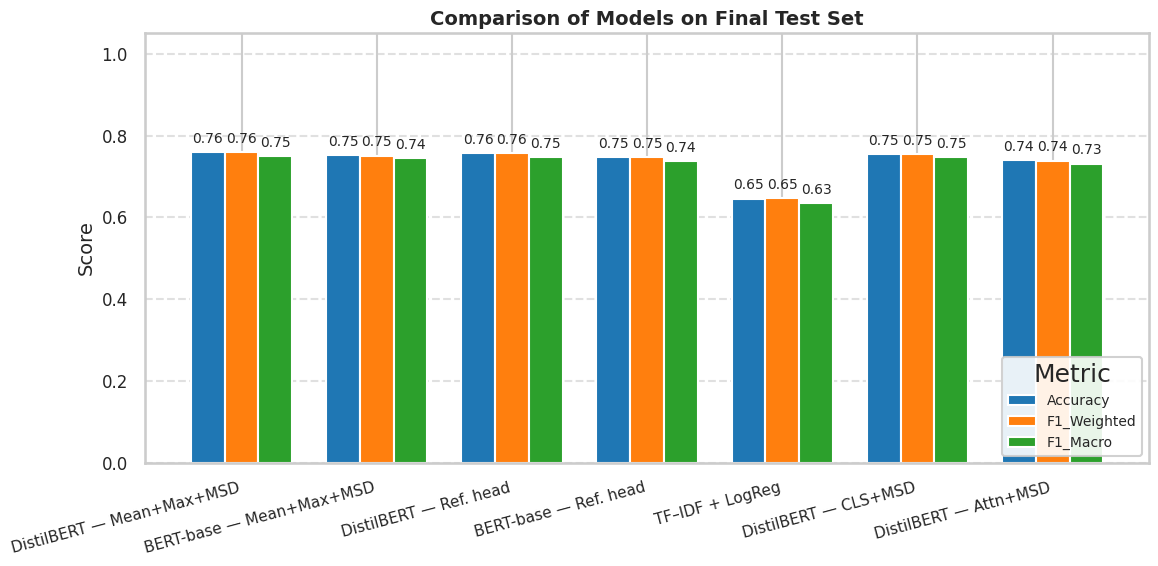

In [ ]:
# === Grouped Bar Chart — Model Comparison (Legend Bottom Right + Bar Labels) ===

# Read the latest comparison table
df = safe_read_csv(CMP_CSV).copy()
df["Model"] = df["Model"].astype(str)

# Define a preferred display order (long form = from CSV, short form = for plotting)
name_map = {
    "DistilBERT — Mean+Max pooling + Projection + MSD": "DistilBERT — Mean+Max+MSD",
    "BERT-base — Mean+Max pooling + Projection + MSD": "BERT-base — Mean+Max+MSD",
    "DistilBERT — Reference head": "DistilBERT — Ref. head",
    "BERT-base — Reference head": "BERT-base — Ref. head",
    "TF-IDF + Logistic Regression": "TF–IDF + LogReg",
    "DistilBERT — CLS+MSD": "DistilBERT — CLS+MSD",
    "DistilBERT — Attention+MSD": "DistilBERT — Attn+MSD",
}

preferred_order = list(name_map.keys())  # long names as they appear in CSV

# Reorder dataframe (keep only models present in table)
order = [m for m in preferred_order if m in set(df["Model"])]
df = df.set_index("Model").loc[order].reset_index()

# Replace with shorter names for plotting
df["DisplayName"] = df["Model"].map(name_map)

# Metrics and plotting geometry
metrics = ["Accuracy", "F1_Weighted", "F1_Macro"]
x = np.arange(len(df))
w = 0.25

# Create figure
plt.figure(figsize=(12, 6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # consistent color palette (blue, orange, green)

bars = []

# Draw grouped bars
for i, (metric, color) in enumerate(zip(metrics, colors)):
    b = plt.bar(x + (i - 1) * w, df[metric].values, width=w, label=metric, color=color)
    bars.append(b)

# Annotate bar values
for b in bars:
    for bar in b:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            h + 0.015,       # slightly more padding above bar
            f"{h:.2f}",
            ha="center", va="bottom", fontsize=10
        )

# X-axis formatting (use shortened names)
plt.xticks(x, df["DisplayName"], rotation=15, ha="right", fontsize=11)

# Y-axis formatting
plt.ylim(0, 1.05)
plt.yticks(fontsize=12)
plt.ylabel("Score", fontsize=14)

# Title
plt.title("Comparison of Models on Final Test Set", fontsize=14, weight="bold")

# Legend formatting
plt.legend(
    title="Metric",
    loc="lower right",
    fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Final export
plt.tight_layout()
plt.savefig("figures/model_scores_grouped_labeled.png", dpi=300, bbox_inches="tight")
plt.show()

**Key takeaways:**
- **Best overall:** *DistilBERT — Mean+Max+MSD* achieves the strongest performance (~0.76 Accuracy / Weighted F1, ~0.75 Macro F1), slightly ahead of BERT-base and other variants.  
- **Transformers vs. traditional:** All transformer-based models outperform the TF–IDF + Logistic Regression baseline by ~0.10–0.12 Macro F1, underscoring the benefit of contextual embeddings.  
- **Head design matters:** The Mean+Max + Projection + MSD head yields more balanced results than CLS or Attention pooling, as seen in higher Macro F1 scores.

## Relative Improvement Over Baseline


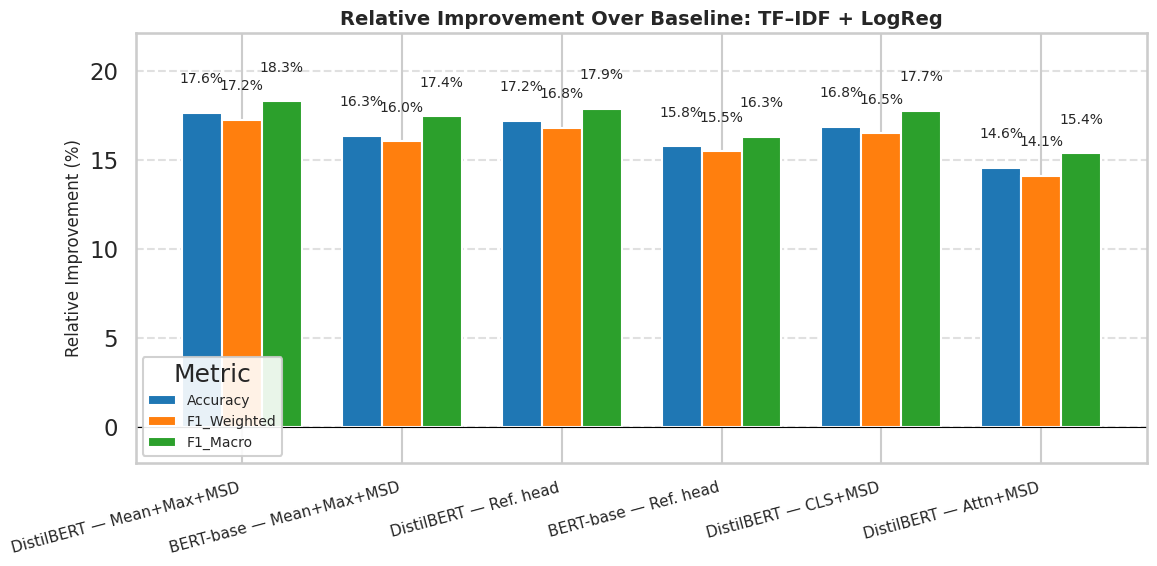

In [ ]:
# === Relative Improvement vs Baseline (Legend Bottom-Left, Clean Labels) ===
df = safe_read_csv(CMP_CSV).copy()
df["Model"] = df["Model"].astype(str)

# --- Name mapping (long → short for figures) ---
name_map = {
    "DistilBERT — Mean+Max pooling + Projection + MSD": "DistilBERT — Mean+Max+MSD",
    "BERT-base — Mean+Max pooling + Projection + MSD": "BERT-base — Mean+Max+MSD",
    "DistilBERT — Reference head": "DistilBERT — Ref. head",
    "BERT-base — Reference head": "BERT-base — Ref. head",
    "TF-IDF + Logistic Regression": "TF–IDF + LogReg",
    "DistilBERT — CLS+MSD": "DistilBERT — CLS+MSD",
    "DistilBERT — Attention+MSD": "DistilBERT — Attn+MSD",
}

df["DisplayName"] = df["Model"].map(name_map).fillna(df["Model"])

# --- Baseline: TF-IDF + Logistic Regression if present, else lowest-Accuracy model ---
logreg_rows = df[df["Model"].str.lower().str.contains("logreg")]
if len(logreg_rows):
    baseline_row = logreg_rows.iloc[0]
else:
    baseline_row = df.loc[df["Accuracy"].idxmin()]

metrics = ["Accuracy", "F1_Weighted", "F1_Macro"]
baseline_scores = baseline_row[metrics]

# --- Compute relative % improvement over baseline ---
imp = df.copy()
for m in metrics:
    imp[m] = (imp[m] - baseline_scores[m]) / (baseline_scores[m] + 1e-12) * 100

# Drop the baseline row itself for plotting
imp = imp[imp["Model"] != baseline_row["Model"]].reset_index(drop=True)

# --- Plotting parameters ---
x = np.arange(len(imp))
w = 0.25
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

plt.figure(figsize=(12,6))

# grouped bars
for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.bar(x + (i-1)*w, imp[metric].values, width=w, label=metric, color=color)

# x-axis labels (short names)
plt.xticks(x, imp["DisplayName"], rotation=15, ha="right", fontsize=11)

# y-axis scaling
ymin = min(0, np.nanmin(imp[metrics].values)) * 1.10
ymax = np.nanmax(imp[metrics].values) * 1.10
plt.ylim(ymin - 2, ymax + 2)
plt.ylabel("Relative Improvement (%)", fontsize=12)

# horizontal line at 0
plt.axhline(0, color="black", linewidth=0.8)

# title with short baseline name
baseline_name_short = name_map.get(baseline_row["Model"], baseline_row["Model"])
plt.title(f"Relative Improvement Over Baseline: {baseline_name_short}",
          fontsize=14, weight="bold")

# legend inside bottom-left
plt.legend(
    title="Metric",
    loc="lower left",
    fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# gridlines for readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

# numeric labels on each bar
for i, metric in enumerate(metrics):
    vals = imp[metric].values
    for xi, v in enumerate(vals):
        voff = 1.5 if v >= 0 else -2.5
        plt.text(
            xi + (i-1)*w,
            v + voff,
            f"{v:.1f}%",
            ha="center",
            va="bottom" if v >= 0 else "top",
            fontsize=10,
        )

plt.tight_layout()
plt.savefig("figures/model_comparison_improvement_clean.png", dpi=300, bbox_inches="tight")
plt.show()

All Transformer models outperform the baseline, with **~15–18% gains** across Accuracy, Weighted F1, and Macro F1.  
- **DistilBERT/BERT Mean+Max+MSD** achieve the best improvements (~18%).  
- **Reference heads** also improve strongly (~16–17%).  
- **CLS/Attention pooling** are weaker but still above baseline.  

Overall, **Mean+Max+MSD** provides the most consistent and balanced gains.

## Confusion Matrix — Best Model (DistilBERT — Mean+Max + Projection + MSD)

Best model (Macro-F1): DistilBERT — Mean+Max pooling + Projection + MSD


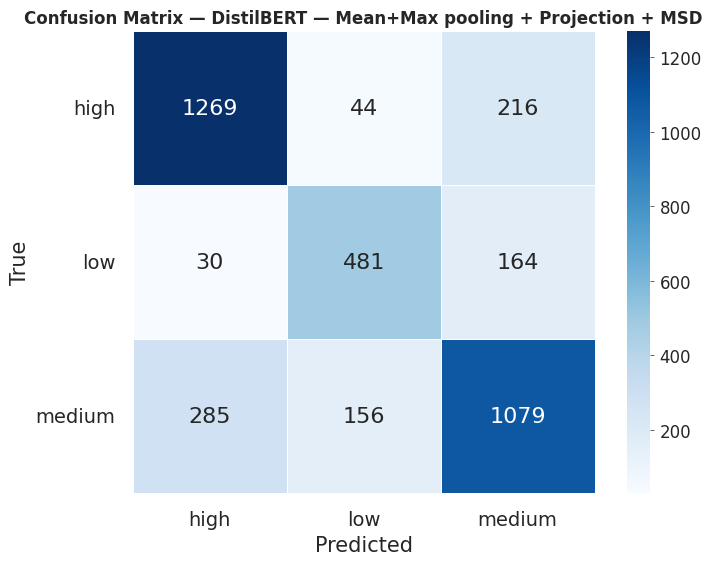

In [ ]:
# === Confusion Matrix — Best Model (Macro-F1) =======================
df = safe_read_csv(CMP_CSV)

# Find best model by Macro-F1
best_idx = df["F1_Macro"].idxmax()
best_model_name = df.loc[best_idx, "Model"]
print(f"Best model (Macro-F1): {best_model_name}")

# --- Try dictionary mapping first ---
family = find_family_from_model_name(best_model_name)
pred_path = PRED_PATHS.get(family, None)

# --- If direct mapping fails, try glob search ---
if pred_path is None or not pred_path.exists():
    print(f"[Warning] Direct mapping failed for {best_model_name}. Trying glob search...")
    candidates = list(BASE.glob("final_test_predictions*.csv"))
    if not candidates:
        raise FileNotFoundError(f"Could not locate predictions file for {best_model_name}")
    # Pick the most recent predictions file by modification time
    pred_path = max(candidates, key=lambda p: p.stat().st_mtime)
    print(f"[Info] Using predictions from: {pred_path}")

# --- Load predictions ---
pred_df = safe_read_csv(pred_path)

# --- Compute confusion matrix ---
labels = sorted(set(pred_df["true_label"]) | set(pred_df["pred_label"]))
cm = confusion_matrix(pred_df["true_label"], pred_df["pred_label"], labels=labels)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# --- Plot confusion matrix ---
plt.figure(figsize=(8,6))
ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels,
    cbar=True, square=True, linewidths=0.7, linecolor="white",
    annot_kws={"size": 16}
)

# Adjust colorbar (legend) style
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)        # tick font size
cbar.ax.tick_params(size=3, width=0.5)   # thinner ticks

# Axis labels
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("True", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14, rotation=0)

# Title
plt.title(f"Confusion Matrix — {best_model_name}", fontsize=12, weight="bold")

plt.tight_layout()
plt.savefig("figures/confusion_matrix_best_model.png", dpi=300, bbox_inches="tight")
plt.show()

- **High risk:** mostly correct (1269), some misclassified as medium (216).  
- **Low risk:** hardest class (481 correct, 164 → medium).  
- **Medium risk:** often confused with high (285) and low (156).  

Model captures **high risk well**, but struggles to clearly separate **medium** from others.

## Per-Class Precision / Recall / F1 — Best Model (DistilBERT — Mean+Max+MSD)

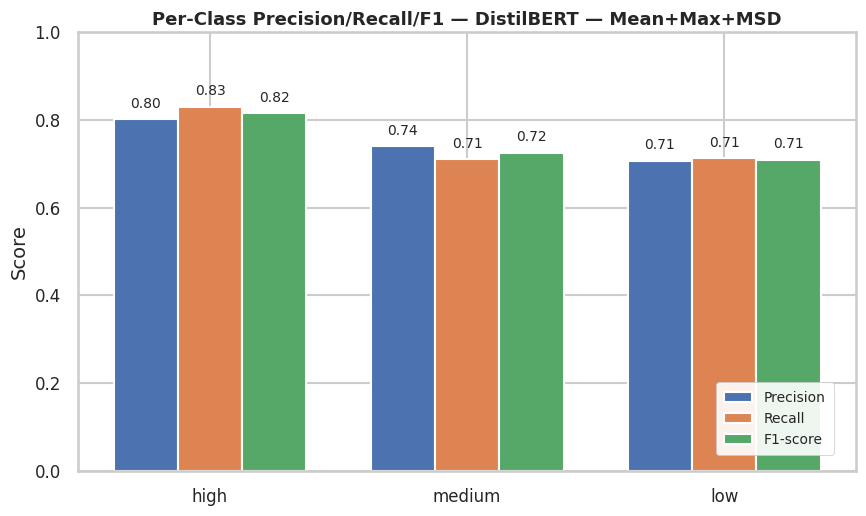

In [ ]:
# === Per-Class Precision / Recall / F1 ===============================

# ------------------------------------------------
# Load best model name
# ------------------------------------------------
df_cmp = safe_read_csv(CMP_CSV)
best_model_name = df_cmp.loc[df_cmp["F1_Macro"].idxmax(), "Model"]
family = find_family_from_model_name(best_model_name)

# Short display names (consistent with other figures)
name_map = {
    "DistilBERT — Mean+Max pooling + Projection + MSD": "DistilBERT — Mean+Max+MSD",
    "BERT-base — Mean+Max pooling + Projection + MSD": "BERT-base — Mean+Max+MSD",
    "DistilBERT — Reference head": "DistilBERT — Ref. head",
    "BERT-base — Reference head": "BERT-base — Ref. head",
    "TF-IDF + Logistic Regression": "TF–IDF + LogReg",
    "DistilBERT — CLS+MSD": "DistilBERT — CLS+MSD",
    "DistilBERT — Attention+MSD": "DistilBERT — Attn+MSD",
}
best_model_name_short = name_map.get(best_model_name, best_model_name)

# ------------------------------------------------
# Locate predictions file for best model
# ------------------------------------------------
pred_path = PRED_PATHS.get(family, None)

# Fallback to a small glob search if direct mapping is missing
if pred_path is None or not pred_path.exists():
    # Minimal, safe candidates based on your pipeline outputs
    candidates = [
        BASE / "final_test_predictions_distilbert_mnmx_msd.csv",
        BASE / "distilbert_mnmx_msd_final" / "best_model" / "predictions.csv",
        BASE / "distilbert_mnmx_msd_final" / "predictions.csv",
        BASE / "bert_poolproj_msd_final" / "predictions.csv",
        BASE / "distilbert_reference_final" / "predictions.csv",
        BASE / "bert_reference_final" / "predictions.csv",
        BASE / "tfidf_logreg_final" / "predictions.csv",
        BASE / "distilbert_cls_msd_final" / "predictions.csv",
        BASE / "distilbert_attn_msd_final" / "predictions.csv",
    ]
    pred_path = next((c for c in candidates if c.exists()), None)

if pred_path is None or not pred_path.exists():
    raise FileNotFoundError(f"Could not find predictions.csv for model family: {family}")

pred_df = safe_read_csv(pred_path)

# ------------------------------------------------
# Extract true + predicted labels
# ------------------------------------------------
y_true = pred_df["true_label"].tolist()
y_pred = pred_df["pred_label"].tolist()

# Define class order explicitly
classes = ["high", "medium", "low"]

# ------------------------------------------------
# Compute metrics
# ------------------------------------------------
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=classes, average=None
)
prec, rec, f1 = np.array(prec), np.array(rec), np.array(f1)

# ------------------------------------------------
# Plot grouped bar chart
# ------------------------------------------------
x = np.arange(len(classes)); w = 0.25

plt.figure(figsize=(9,5.5))
plt.bar(x - w, prec, width=w, label="Precision")
plt.bar(x,     rec,  width=w, label="Recall")
plt.bar(x + w, f1,   width=w, label="F1-score")

# Format axes
plt.xticks(x, classes, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.ylabel("Score", fontsize=14)
plt.title(f"Per-Class Precision/Recall/F1 — {best_model_name_short}", fontsize=13, weight="bold")

# Legend inside (bottom-right, small)
leg = plt.legend(
    loc="lower right",
    bbox_to_anchor=(0.98, 0.02),
    frameon=True,
    framealpha=0.9,
    fancybox=True,
    fontsize=10,
    borderpad=0.6
)
leg.get_frame().set_linewidth(0.6)

# Add values above bars
for xi, (p, r, f_) in enumerate(zip(prec, rec, f1)):
    for offset, val in [(-w, p), (0, r), (w, f_)]:
        plt.text(xi + offset, val + 0.02, f"{val:.2f}",
                 ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("figures/per_class_prf_best_model.png", dpi=300, bbox_inches="tight")
plt.show()

- **High:** P=0.80, R=0.83, F1=0.82 → strongest class; the model reliably finds high-risk posts.
- **Medium:** P=0.74, R=0.71, F1=0.72 → moderate precision; recall is the weakest, indicating misses (often predicted as high/low).
- **Low:** P=0.71, R=0.71, F1=0.71 → balanced but lowest overall performance.

**Takeaway:** Performance is best for **high**, while **medium** remains the most ambiguous class. If optimizing one class, consider recall-focused tuning for *medium* (e.g., class weights/thresholding).

## Cross-Validation Metrics — DistilBERT (Mean+Max+MSD)

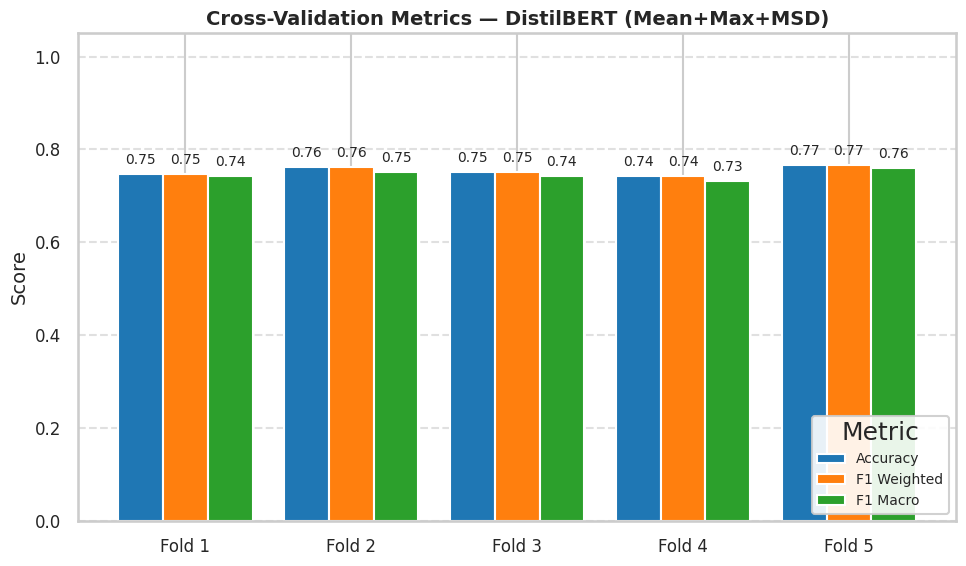

In [ ]:
# === Cross-Validation Metrics — Grouped Bars (with Labels) ============
if CV_METRICS_CSV.exists():
    cv = pd.read_csv(CV_METRICS_CSV)
    folds = len(cv)
    x = np.arange(folds)
    w = 0.27  # bar width

    plt.figure(figsize=(10,6))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

    # Grouped bars
    bars = []
    bars.append(plt.bar(x - w, cv['accuracy'],     width=w, label="Accuracy",     color=colors[0]))
    bars.append(plt.bar(x,      cv['f1_weighted'], width=w, label="F1 Weighted", color=colors[1]))
    bars.append(plt.bar(x + w,  cv['f1_macro'],    width=w, label="F1 Macro",    color=colors[2]))

    # Annotate values on each bar
    for b in bars:
        for bar in b:
            h = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2,
                h + 0.015,             # padding above bar
                f"{h:.2f}",            # 2 decimal places
                ha="center", va="bottom", fontsize=10
            )

    # X-axis formatting
    plt.xticks(x, [f"Fold {i}" for i in range(1, folds+1)], fontsize=12)

    # Y-axis formatting
    plt.ylim(0, 1.05)
    plt.yticks(fontsize=12)
    plt.ylabel("Score", fontsize=14)

    # Title (shortened to fit dissertation figures cleanly)
    plt.title("Cross-Validation Metrics — DistilBERT (Mean+Max+MSD)", fontsize=14, weight="bold")

    # Legend inside bottom-right
    plt.legend(
        title="Metric",
        loc="lower right",
        fontsize=10,
        frameon=True,
        facecolor="white",
        framealpha=0.9
    )

    # Gridlines
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    # Save + show
    plt.tight_layout()
    plt.savefig("figures/cv_metrics_grouped_bars.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print(f"[Info] CV metrics file not found: {CV_METRICS_CSV}. Skipping plot.")

The five-fold cross-validation demonstrates **consistent performance** across folds:

- **Accuracy:** 0.74–0.77  
- **F1 (Weighted):** 0.74–0.77  
- **F1 (Macro):** 0.73–0.76  

**Observation:** The stability across folds confirms that the model generalises well and is not overly dependent on a particular data split. This reliability supports its use as the final model.

## Aggregated Confusion Matrix — Cross-Validation (DistilBERT, Mean+Max+MSD)

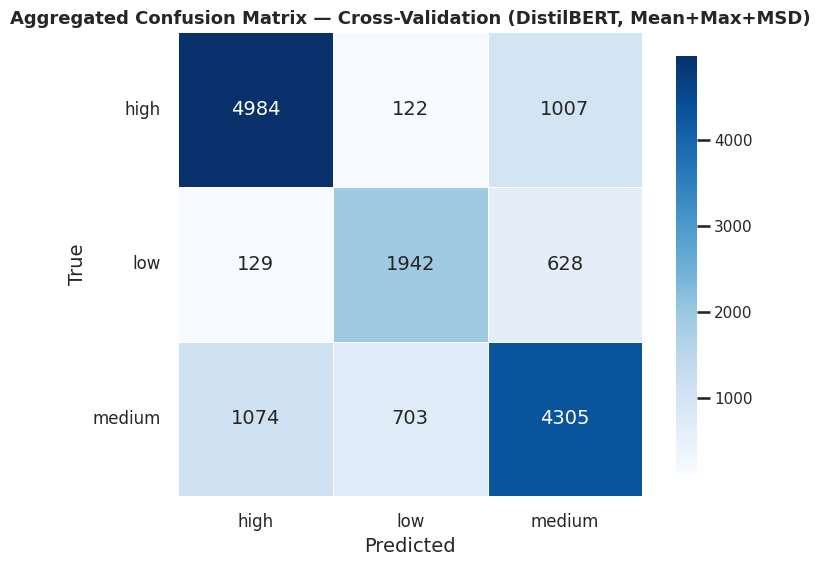

In [ ]:
# === Aggregated CV Confusion Matrix (Styled + Small Colorbar Font) ===
pred_files = sorted(glob.glob(CV_PRED_GLOB))

if len(pred_files):
    parts = []
    for p in pred_files:
        try:
            dfp = pd.read_csv(p)[["true_label", "pred_label"]]
            parts.append(dfp)
        except Exception:
            print(f"[Warning] Skipped unreadable file: {p}")

    if len(parts):
        # Combine all folds' predictions
        cv_all = pd.concat(parts, ignore_index=True)

        # Define label order
        labels = sorted(cv_all["true_label"].unique().tolist())

        # Confusion matrix
        cm_cv = confusion_matrix(cv_all["true_label"], cv_all["pred_label"], labels=labels)

        # Plot
        plt.figure(figsize=(8,6))
        ax = sns.heatmap(
            cm_cv,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar=True, cbar_kws={"shrink": 0.9}, square=True,
            annot_kws={"size":14}, linewidths=0.6, linecolor="white"
        )

        # Style colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11)

        # Axis formatting
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("True", fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12, rotation=0)

        # Title (shortened for dissertation figure captions)
        plt.title("Aggregated Confusion Matrix — Cross-Validation (DistilBERT, Mean+Max+MSD)",
                  fontsize=13, weight="bold")

        plt.tight_layout()
        plt.savefig("figures/cv_confusion_matrix_aggregated.png", dpi=300, bbox_inches="tight")
        plt.show()
    else:
        print("[Info] No readable CV prediction files found. Skipping aggregated CV CM.")
else:
    print(f"[Info] No CV prediction files matched: {CV_PRED_GLOB}. Skipping.")

The aggregated confusion matrix over all five folds shows:

- **High-risk posts** are well-identified, with 4,984 correct predictions, though some are confused with medium-risk.  
- **Low-risk posts** are moderately captured (1,942 correct), but often misclassified as medium-risk, reflecting overlap in linguistic cues.  
- **Medium-risk posts** achieve strong recognition (4,305 correct), though with some spillover into high-risk predictions.  

**Observation:** The model demonstrates reliable detection across all classes, with strongest performance in distinguishing high and medium risk, while low-risk remains the most challenging to separate.

## True vs Predicted Label Distribution — DistilBERT (Mean+Max pooling + Projection + MSD)

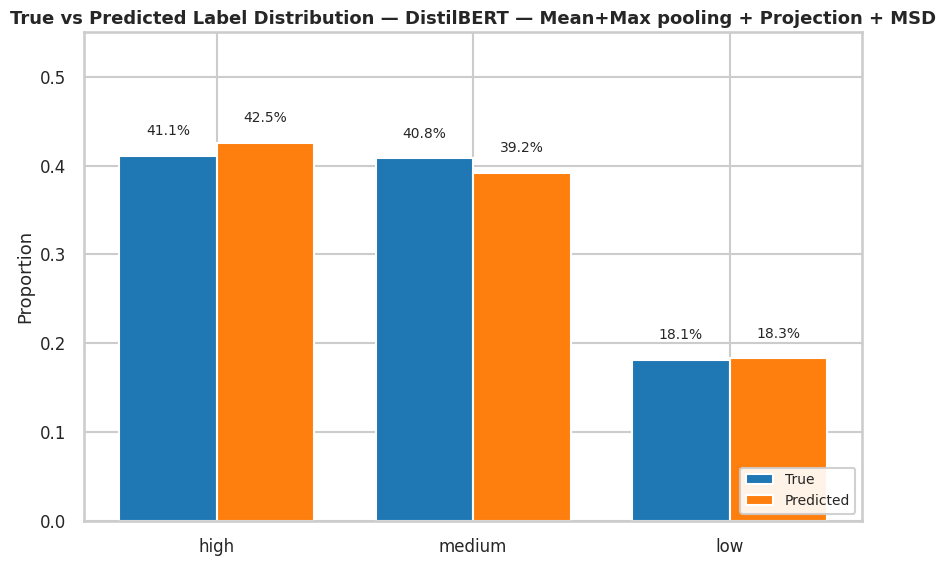

In [ ]:
# === True vs Predicted Distribution — Final Test ============
df = safe_read_csv(CMP_CSV)

# Identify best model by Macro-F1
best_model_name = df.loc[df["F1_Macro"].idxmax(), "Model"]
family = find_family_from_model_name(best_model_name)

# Locate predictions file for best model
pred_path = PRED_PATHS.get(family, None)
if pred_path is None or not pred_path.exists():
    candidates = [
        BASE / "final_test_predictions_distilbert_poolproj_msd.csv",
        BASE / "bert_poolproj_msd_final" / "predictions.csv",
        BASE / "distilbert_reference_final" / "predictions.csv",
        BASE / "bert_reference_final" / "predictions.csv",
        BASE / "tfidf_logreg_final" / "predictions.csv",
    ]
    pred_path = next((c for c in candidates if c.exists()), None)
    if pred_path is None:
        raise FileNotFoundError(f"Could not locate predictions.csv for {best_model_name}")
    print(f"[Info] Using predictions from: {pred_path}")

pred_df = safe_read_csv(pred_path)

# --- Step 1. Compute distributions ---
true_counts = pred_df["true_label"].value_counts()
pred_counts = pred_df["pred_label"].value_counts()

# Ensure consistent label order
labels = [c for c in ["high", "medium", "low"] if c in set(true_counts.index) | set(pred_counts.index)]
if not labels:
    labels = sorted(set(true_counts.index) | set(pred_counts.index))

# Convert to proportions
true_vals = (true_counts.reindex(labels, fill_value=0) / true_counts.sum()).values
pred_vals = (pred_counts.reindex(labels, fill_value=0) / pred_counts.sum()).values

# --- Step 2. Plot ---
x = np.arange(len(labels)); w = 0.38
plt.figure(figsize=(9,6))

b1 = plt.bar(x - w/2, true_vals, width=w, label="True", color="#1f77b4")
b2 = plt.bar(x + w/2, pred_vals, width=w, label="Predicted", color="#ff7f0e")

# X/Y formatting
plt.xticks(x, labels, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.55)
plt.ylabel("Proportion", fontsize=13)

# Title (shortened for readability)
plt.title(f"True vs Predicted Label Distribution — {best_model_name}",
          fontsize=13, weight="bold")

# Legend inside bottom-right
plt.legend(
    loc="lower right", fontsize=10,
    frameon=True, facecolor="white", framealpha=0.9
)

# Add percentage labels
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.02,
            f"{h*100:.1f}%",
            ha="center", va="bottom", fontsize=10
        )

plt.tight_layout()
plt.savefig("figures/final_test_true_vs_pred.png", dpi=300, bbox_inches="tight")
plt.show()

This plot compares the proportion of **true labels** against the **model’s predictions**:

- **High-risk:** True = 41.1%, Predicted = 42.5% → slightly **overestimated**.  
- **Medium-risk:** True = 40.8%, Predicted = 39.2% → slightly **underestimated**.  
- **Low-risk:** True = 18.1%, Predicted = 18.3% → almost perfectly aligned.  

**Observation:**  
The predicted label distribution closely mirrors the true distribution, indicating that the model does not suffer from strong prediction bias toward any class. Minor deviations exist (slight over-prediction of high-risk and under-prediction of medium-risk), but overall class balance is well preserved.

## Top Misclassifications — Final Test (DistilBERT — Mean+Max pooling + Projection + MSD)


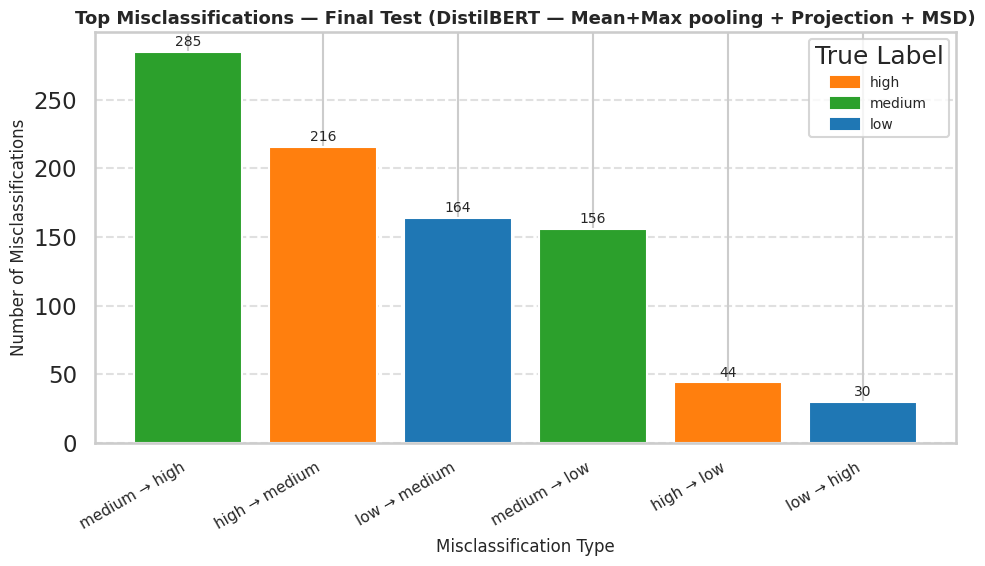

In [ ]:
# === Error Analysis — Top Misclassifications (Option A with Label Colors) ===

# Load predictions for best model
df_cmp = safe_read_csv(CMP_CSV)
best_model_name = df_cmp.loc[df_cmp["F1_Macro"].idxmax(), "Model"]
family = find_family_from_model_name(best_model_name)

pred_path = PRED_PATHS.get(family, None)
if pred_path is None or not pred_path.exists():
    raise FileNotFoundError("Could not find predictions file for best model.")
pred_df = safe_read_csv(pred_path)

# Count misclassifications
pairs = [(t, p) for t, p in zip(pred_df["true_label"], pred_df["pred_label"]) if t != p]
pair_counts = Counter([f"{t} → {p}" for t, p in pairs])

# Sort misclassifications by frequency
mis_df = pd.DataFrame(pair_counts.items(), columns=["Misclassification", "Count"])
mis_df = mis_df.sort_values("Count", ascending=False).reset_index(drop=True)

# Extract true label from "true → pred"
mis_df["TrueLabel"] = mis_df["Misclassification"].str.split("→").str[0].str.strip()

# Color map by true label
color_map = {"high": "#ff7f0e", "medium": "#2ca02c", "low": "#1f77b4"}
colors = mis_df["TrueLabel"].map(color_map)

# --- Plot ---
plt.figure(figsize=(10,6))
bars = plt.bar(mis_df["Misclassification"], mis_df["Count"], color=colors)

# Rotate X-axis labels for readability
plt.xticks(rotation=30, ha="right", fontsize=11)
plt.ylabel("Number of Misclassifications", fontsize=12)
plt.xlabel("Misclassification Type", fontsize=12)

plt.title(f"Top Misclassifications — Final Test ({best_model_name})",
          fontsize=13, weight="bold")

# Add value labels above bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 2, str(int(h)),
             ha="center", va="bottom", fontsize=10)

# Legend for true labels
handles = [plt.Rectangle((0,0),1,1, color=color_map[l]) for l in color_map]
plt.legend(handles, color_map.keys(), title="True Label",
           loc="upper right", frameon=True, fontsize=10)

# Gridlines for clarity
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("figures/misclassifications_optionA_colored.png", dpi=300, bbox_inches="tight")
plt.show()

This plot highlights the most common misclassifications made by the model:

- **Medium → High (285 cases):** The largest source of error; the model often mistakes medium-risk posts as high-risk.  
- **High → Medium (216 cases):** High-risk posts sometimes softened to medium.  
- **Low → Medium (164 cases):** Low-risk posts confused as medium.  
- **Medium → Low (156 cases):** Some medium-risk posts downgraded to low.  
- **High → Low (44 cases):** Less frequent, but critical since high-risk is underestimated.  
- **Low → High (30 cases):** Rare overestimation from low-risk to high-risk.  

**Observation:**  
Most errors occur between **adjacent risk levels (medium ↔ high, low ↔ medium)**, which is expected due to their semantic closeness. Direct flips between **low and high** are rare, showing that the model generally respects the severity ordering of risk levels.

# External Evaluation Data Collection (Unseen Reddit Posts)

**Objective.** To assess generalization, we curated a fresh, non-overlapping test set of Reddit posts not used in training, validation, or earlier EDA.

**Sources.** The same mental-health–related subreddits as the training corpus (e.g., r/depression, r/anxiety, r/SuicideWatch, r/mentalhealth, etc.).

**Sampling strategy.**
- Queried each subreddit via the PRAW API and retrieved up to **100 top posts** per community (configurable to `.new` or `.hot` as needed).
- Posts with empty, `[removed]`, or `[deleted]` bodies were excluded.
- For each subreddit batch, **duplicates were removed** by unique post `id`.

**Captured fields.** `subreddit`, `title`, `body`, `created_utc` (ISO-8601, UTC), `score`, `num_comments`, `id`, `url`.

**Output & provenance.**
- Aggregated into a single DataFrame and saved as  
  `/content/drive/MyDrive/Dissertation/reddit_new_raw_posts.csv`.
- This file is reserved **strictly for external evaluation** (no training/finetuning) to avoid leakage.

**Ethical and platform compliance.**
- Accessed public content only, in line with Reddit’s API Terms.
- No user identifiers beyond post IDs/URLs are analyzed or reported.
- All results are presented in aggregate; no quotes from private or deleted content.

**Notes.**
- Switching `.top` to `.new` enables recency-based sampling to test temporal robustness.
- The collection script prints per-subreddit counts to document coverage and potential gaps.

In [ ]:
# ======================================================================
# Collect New Reddit Data for Model Evaluation
# This script fetches unseen posts to test the trained model.
# ======================================================================

# ----------------------------------------------------------------------
# Initialize empty list to store new post data
# ----------------------------------------------------------------------
new_posts = []  # Will hold all fetched post dictionaries

# ----------------------------------------------------------------------
# Loop through each subreddit and collect posts
# ----------------------------------------------------------------------
for sub in subreddits:  # Iterate over subreddit list
    subreddit = reddit.subreddit(sub)  # Get subreddit object from PRAW

    # --------------------------------------------------------------
    # Fetch top posts (change .top to .new or .hot if needed)
    # --------------------------------------------------------------
    posts = []  # temporary list to hold only this sub's posts
    for post in subreddit.top(limit=100):  # or .new / .hot if needed
        if post.selftext and post.selftext.lower() not in ["[removed]", "[deleted]"]:
            posts.append({
                "subreddit": sub,
                "title": post.title,
                "body": post.selftext,
                "created_utc": datetime.fromtimestamp(post.created_utc, tz=timezone.utc).isoformat().replace("+00:00", "Z"),
                "score": post.score,
                "num_comments": post.num_comments,
                "id": post.id,
                "url": post.url
            })

    # Drop duplicates within this subreddit batch
    if posts:
        _df_sub = pd.DataFrame(posts).drop_duplicates(subset="id")
        posts = _df_sub.to_dict(orient="records")

    new_posts.extend(posts)
    print(f"Collected {len(posts)} posts from r/{sub}")  # show per-subreddit count

# ----------------------------------------------------------------------
# Save collected new data to CSV
# This dataset will be used for external evaluation only (no training)
# ----------------------------------------------------------------------
df_new_raw = pd.DataFrame(new_posts)  # Convert list to DataFrame
df_new_raw.to_csv("/content/drive/MyDrive/Dissertation/reddit_new_raw_posts.csv", index=False)  # Save as CSV
print("New evaluation data saved to 'reddit_new_raw_posts.csv'")  # Confirmation

Collected 95 posts from r/depression
Collected 53 posts from r/anxiety
Collected 84 posts from r/mentalhealth
Collected 80 posts from r/SuicideWatch
Collected 3 posts from r/OCD
Collected 96 posts from r/BPD
Collected 93 posts from r/ptsd
Collected 89 posts from r/lonely
Collected 91 posts from r/selfharm
Collected 96 posts from r/therapy
Collected 17 posts from r/depression_help
Collected 0 posts from r/socialanxiety
Collected 6 posts from r/mentalillness
Collected 90 posts from r/DecidingToBeBetter
Collected 2 posts from r/Anxietyhelp
Collected 98 posts from r/KindVoice
Collected 82 posts from r/griefsupport
Collected 95 posts from r/insomnia
Collected 81 posts from r/cPTSD
Collected 79 posts from r/EMDR
New evaluation data saved to 'reddit_new_raw_posts.csv'


## External Evaluation Data Preprocessing

**Objective.** To ensure comparability with the training corpus, the newly collected Reddit posts were preprocessed using the **same pipeline** applied earlier.

**Steps performed.**
- **Missing text handling.** Empty `title` or `body` fields were filled with blank strings.  
- **Text unification.** Concatenated `title` and `body` into a single `text` field.  
- **Cleaning.** Applied the previously defined `preprocess()` function, which standardizes casing, removes URLs/mentions/special characters, eliminates stopwords, and lemmatizes tokens. Output stored as `clean_text`.  
- **Temporal features.** From `created_utc`, extracted `date` and `hour` for potential time-based analysis.  

**Output.** The cleaned evaluation set was saved as:  
`/content/drive/MyDrive/Dissertation/reddit_new_cleaned_posts.csv`

**Rationale.**  
Using an **identical preprocessing pipeline** guarantees that the evaluation data is processed under the same assumptions and constraints as the training set, avoiding preprocessing bias.  

In [ ]:
# ===========================
# Apply Existing Preprocessing to New Raw Data
# ===========================

# Load new raw data
df_new = pd.read_csv("/content/drive/MyDrive/Dissertation/reddit_new_raw_posts.csv")

# Fill missing values in title and body
df_new['title'] = df_new['title'].fillna('')
df_new['body'] = df_new['body'].fillna('')

# Combine title and body into a single text column
df_new['text'] = df_new['title'] + ' ' + df_new['body']
df_new['text'] = df_new['text'].astype(str)  # ensure text format

# Apply existing preprocessing function from your earlier code
df_new['clean_text'] = df_new['text'].apply(preprocess)

# Extract date and hour if timestamp column exists
if 'created_utc' in df_new.columns:
    df_new['created_utc'] = pd.to_datetime(df_new['created_utc'], errors='coerce')
    df_new['date'] = df_new['created_utc'].dt.date
    df_new['hour'] = df_new['created_utc'].dt.hour

# Save the cleaned new dataset
df_new.to_csv("/content/drive/MyDrive/Dissertation/reddit_new_cleaned_posts.csv", index=False)
print("Cleaned new data saved to 'reddit_new_cleaned_posts.csv'")

Cleaned new data saved to 'reddit_new_cleaned_posts.csv'


## Inference on Unseen Reddit Posts (Custom DistilBERT Package)

**What this does**
- **Rebuilds** the exact custom head used in training: DistilBERT → **Mean+Max pooling** → **GELU projection** → **Multi-Sample Dropout** (MSD) classifier.
- **Loads** the tokenizer + weights + label maps from your saved package:
  - `.../distilbert_mnmx_msd_final/best_model/model_meta.json`
  - `.../pytorch_model.bin`
- **Runs batched prediction** (GPU if available) on `/Dissertation/reddit_new_cleaned_posts.csv`.

**Outputs**
- File: `/content/drive/MyDrive/Dissertation/reddit_unseen_predictions.csv`
- Columns added:
  - `predicted_risk_level` (string class)
  - `prob_<class>` for each class (softmax probabilities)

**Key details**
- Max sequence length: **512** (with truncation & dynamic padding).
- Batch size: **32**.
- Handles DDP prefixes / training buffers when loading the state dict.
- Prints a **prediction distribution** sanity check at the end.

**Why this matters**
Using the saved **model_meta.json** guarantees the inference graph matches training exactly, avoiding config drift and making results reproducible on truly unseen data.

In [ ]:
# =====================================================================
# Inference on Unseen Data with the Custom DistilBERT Package
#   - Rebuilds the custom architecture from model_meta.json
#   - Loads weights from pytorch_model.bin (no HF config.json required)
#   - Outputs predicted labels + per-class probabilities
# =====================================================================

# ----------------------------
# Paths
# ----------------------------
BASE = Path("/content/drive/MyDrive/Dissertation")                     # Root artifacts directory
MODEL_DIR = BASE / "distilbert_mnmx_msd_final" / "best_model"          # Trained custom package directory
UNSEEN_CSV = BASE / "reddit_new_cleaned_posts.csv"                     # Unseen input data
OUT_CSV    = BASE / "reddit_unseen_predictions.csv"                    # Output predictions file

# ----------------------------
# Define the custom model exactly as used in training
# ----------------------------
class _MeanMaxPool(nn.Module):
    """Mask-aware mean+max pooling over token representations."""
    def forward(self, last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).float()               # (B, L) -> (B, L, 1)
        x = last_hidden_state * mask                              # zero-out pads
        denom = mask.sum(dim=1).clamp(min=1e-9)                   # avoid divide-by-zero
        mean_pool = x.sum(dim=1) / denom                          # (B, H)
        x_masked = x + (1.0 - mask) * (-1e9)                      # push pads to -inf
        max_pool, _ = x_masked.max(dim=1)                         # (B, H)
        return torch.cat([mean_pool, max_pool], dim=1)            # (B, 2H)

class _MSDHead(nn.Module):
    """Multi-Sample Dropout (MSD) classification head."""
    def __init__(self, in_features: int, num_labels: int, p_list=(0.10, 0.20, 0.30, 0.40, 0.50)):
        super().__init__()
        self.dropouts = nn.ModuleList([nn.Dropout(p) for p in p_list])
        self.out = nn.Linear(in_features, num_labels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = [self.out(d(x)) for d in self.dropouts]          # list[(B, C)]
        return torch.stack(logits, dim=0).mean(dim=0)             # (B, C)

class DistilForRiskMeanMax(nn.Module):
    """
    DistilBERT encoder -> mean+max pooling -> GELU projection -> MSD classification head.
    Forward returns {"loss": None, "logits": logits} for compatibility with HF Trainer-style outputs.
    """
    def __init__(
        self,
        model_name: str = "distilbert-base-uncased",
        num_labels: int = 3,
        dropout: float = 0.2,
        id2label: Dict[int, str] | None = None,
        label2id: Dict[str, int] | None = None,
        class_weights: torch.Tensor | None = None,
        label_smoothing: float = 0.05,
    ):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)     # DistilBERT encoder
        hidden = self.backbone.config.dim                         # hidden width (e.g., 768)
        self.pool = _MeanMaxPool()                                # mean+max pooling
        self.proj = nn.Sequential(                                # lightweight projection
            nn.Linear(2 * hidden, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.head = _MSDHead(hidden, num_labels)                  # MSD classifier

        # Store label maps for convenience (not required for inference)
        self.config = self.backbone.config
        if id2label is not None:
            self.config.id2label = id2label
        if label2id is not None:
            self.config.label2id = label2id

        # Training-time items kept for signature parity; unused during inference
        self.register_buffer("class_weights", class_weights if class_weights is not None else None)
        self.label_smoothing = float(label_smoothing)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        out = self.backbone(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        feats = self.proj(self.pool(out.last_hidden_state, attention_mask))   # (B, H)
        logits = self.head(feats)                                            # (B, C)
        return {"loss": None, "logits": logits}

# ----------------------------
# Utility: load custom package (tokenizer + meta + weights)
# ----------------------------
def load_custom_model_package(model_dir: Path) -> tuple[AutoTokenizer, DistilForRiskMeanMax, Dict[int, str]]:
    """
    Reconstruct the model from saved metadata and load weights.
    Returns: (tokenizer, model, id2label)
    """
    # Paths
    meta_path = model_dir / "model_meta.json"
    weights_path = model_dir / "pytorch_model.bin"
    if not meta_path.exists():
        raise FileNotFoundError(f"Missing model_meta.json at: {meta_path}")
    if not weights_path.exists():
        raise FileNotFoundError(f"Missing pytorch_model.bin at: {weights_path}")

    # Metadata
    with open(meta_path) as f:
        meta = json.load(f)
    backbone        = meta.get("backbone", "distilbert-base-uncased")
    num_labels      = int(meta["num_labels"])
    id2label        = {int(k): v for k, v in meta["id2label"].items()}
    label2id        = {str(k): int(v) for k, v in meta["label2id"].items()}
    dropout         = float(meta.get("dropout", 0.2))
    label_smoothing = float(meta.get("label_smoothing", 0.05))

    # Tokenizer (saved alongside the package)
    tokenizer = AutoTokenizer.from_pretrained(str(model_dir))

    # Model (class_weights and smoothing not used in inference)
    model = DistilForRiskMeanMax(
        model_name=backbone,
        num_labels=num_labels,
        dropout=dropout,
        id2label=id2label,
        label2id=label2id,
        class_weights=None,
        label_smoothing=label_smoothing,
    )

    # Load weights; drop training-only buffers if present; strip DDP prefixes if any
    state = torch.load(weights_path, map_location="cpu")
    if "class_weights" in state:
        state.pop("class_weights")
    if any(k.startswith("module.") for k in state.keys()):
        state = {k.replace("module.", "", 1): v for k, v in state.items()}
    model.load_state_dict(state, strict=True)
    model.eval()

    return tokenizer, model, id2label

# ----------------------------
# Load unseen data and run predictions
# ----------------------------
def predict_unseen(
    csv_path: Path,
    model_dir: Path,
    out_path: Path,
    text_column: str = "clean_text",
    batch_size: int = 32,
    max_length: int = 512
) -> pd.DataFrame:
    """Run batched inference and persist predictions + probabilities."""
    # Load data
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing unseen CSV: {csv_path}")
    df = pd.read_csv(csv_path)
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in: {csv_path}")
    print(f"Loaded unseen dataset with {len(df)} rows")

    # Load package
    tokenizer, model, id2label = load_custom_model_package(model_dir)

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Inference device: {device}")

    # Prediction loop
    all_preds: List[int] = []
    all_probs: List[List[float]] = []

    for start in tqdm(range(0, len(df), batch_size), desc="Predicting"):
        batch_texts = df[text_column].iloc[start:start+batch_size].astype(str).tolist()
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            out = model(**enc)
            logits = out["logits"]                                 # (B, C)
            probs = F.softmax(logits, dim=1)                       # (B, C)
            preds = probs.argmax(dim=1)                            # (B,)

        all_preds.extend(preds.cpu().tolist())
        all_probs.extend(probs.cpu().tolist())

    # Map ids to labels using saved metadata
    id2label_list = [id2label[i] for i in sorted(id2label)]
    df["predicted_risk_level"] = [id2label[i] for i in all_preds]

    # Attach probabilities with column names in id order for clarity
    prob_cols = [f"prob_{lbl}" for lbl in id2label_list]
    df[prob_cols] = pd.DataFrame(all_probs, index=df.index)

    # Save
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False)
    print(f"Predictions saved to: {out_path}")

    # Quick distribution printout
    dist = df["predicted_risk_level"].value_counts(normalize=True).sort_index()
    print("\nPrediction distribution (proportion):")
    print(dist)

    return df

# ----------------------------
# Execute
# ----------------------------
_ = predict_unseen(
    csv_path=UNSEEN_CSV,
    model_dir=MODEL_DIR,
    out_path=OUT_CSV,
    text_column="clean_text",
    batch_size=32,
    max_length=512
)

Loaded unseen dataset with 1330 rows
Inference device: cuda


Predicting:   0%|          | 0/42 [00:00<?, ?it/s]

Predictions saved to: /content/drive/MyDrive/Dissertation/reddit_unseen_predictions.csv

Prediction distribution (proportion):
predicted_risk_level
high      0.320301
low       0.264662
medium    0.415038
Name: proportion, dtype: float64


In [ ]:
# ============================================
# Load predictions from CSV
# ============================================
df_new = pd.read_csv("/content/drive/MyDrive/Dissertation/reddit_unseen_predictions.csv")

# ============================================
# Display count of each predicted risk level
# ============================================
print(df_new['predicted_risk_level'].value_counts())

predicted_risk_level
medium    552
high      426
low       352
Name: count, dtype: int64


## Distribution of Predicted Risk Levels on Unseen Reddit Data  

- **Total posts evaluated:** 1,330  
- **Predicted distribution:**  
  - Medium risk → **552 posts** (41.5%)  
  - High risk → **426 posts** (32.0%)  
  - Low risk → **352 posts** (26.5%)  

The model assigns most unseen posts to **medium risk**, with a balanced spread across classes. Compared to the training/test data, the unseen set shows **slightly fewer high-risk predictions** and **more medium/low-risk predictions**, suggesting the model adopts a more cautious stance on fresh data.  

Loaded unseen predictions with 1330 rows


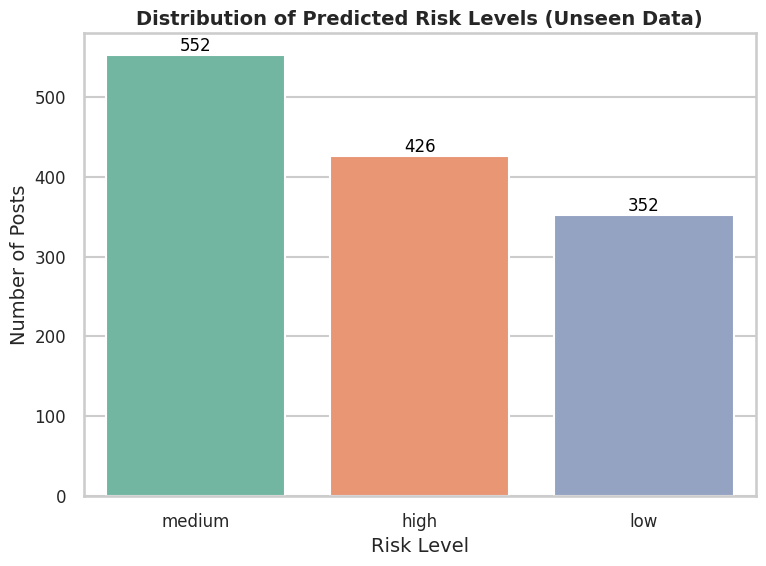

In [ ]:
# ============================================
# Plot distribution of predicted risk levels
# ============================================

# Path to your saved predictions CSV
PRED_CSV = "/content/drive/MyDrive/Dissertation/reddit_unseen_predictions.csv"

# Load dataframe
df_unseen = pd.read_csv(PRED_CSV)
print(f"Loaded unseen predictions with {len(df_unseen)} rows")

# Use the correct column name from your CSV
label_col = "predicted_risk_level"   # <-- adjust if your CSV has a different name

# Count frequency of each predicted label
counts = df_unseen[label_col].value_counts().reset_index()
counts.columns = ["Risk Level", "Count"]

# Set style
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(8,6))
ax = sns.barplot(
    x="Risk Level",
    y="Count",
    data=counts,
    palette="Set2"
)

# Add numbers above bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Titles and labels
plt.title("Distribution of Predicted Risk Levels (Unseen Data)", fontsize=14, weight="bold")
plt.xlabel("Risk Level", fontsize=14)
plt.ylabel("Number of Posts", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()

## Filtering High-Risk Predictions

To focus on the most critical cases, the unseen dataset predictions were filtered to extract only those posts classified as **high risk** by the DistilBERT model.  
These posts were then saved as a separate CSV file (`reddit_high_risk_posts.csv`) for further qualitative analysis and inspection.


In [ ]:
# ============================================
# Filter and save high-risk predictions
# ============================================

# Select only rows where the predicted risk level is "high-risk"
high_risk_df = df_new[df_new['predicted_risk_level'] == 'high-risk']

# Save the filtered DataFrame to a CSV file
high_risk_df.to_csv(
    "/content/drive/MyDrive/Dissertation/reddit_high_risk_posts.csv",  # Output path
    index=False                                                        # Do not include index column in CSV
)

# Print confirmation message
print("High-risk posts saved to 'reddit_high_risk_posts.csv'")

High-risk posts saved to 'reddit_high_risk_posts.csv'
